In this notebook, we test the GCN with different loss metrics to see which yields the most desirable performance.

### imports and setup

In [1]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [2]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# import packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from lorenz import lorenzDataset, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, plot_model_results
from models import NaiveConstant, NaiveZero

from spektral.data import MixedLoader

from datetime import datetime

2023-02-13 14:26:28.429047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('no GPU device found')
else:
    print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


2023-02-13 14:26:39.442970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### prepare data

In [5]:
# only uncomment each line if testing a non-default parameter
dataset = lorenzDataset(
    n_samples=10_000,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

reading Lorenz data from stored file


In [6]:
train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]


In [7]:
train_loader = MixedLoader(dataset=train, batch_size=32, shuffle=False)
val_loader = MixedLoader(dataset=val, batch_size=32, shuffle=False)


In [8]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:01.928719
time to get std&mean from X1: 0:00:01.869557
time to get std&mean from X2: 0:00:00.753674
time to get means: 0:00:04.654163
time to normalize data: 0:00:02.472930


inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

In [9]:
# fig, (ax0, ax1) = plot_data(train, val, test, node=0)

# plt.tight_layout()
# plt.show()

## compare loss metrics

In [17]:
# import error metrics
from tensorflow.keras.metrics import RootMeanSquaredError, Metric
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredLogarithmicError, Loss

In [20]:
print(RootMeanSquaredError().name)
print(MeanSquaredError().name)
print(isinstance(RootMeanSquaredError(), Loss))
print(isinstance(RootMeanSquaredError(), Metric))
print(isinstance(MeanSquaredError(), Loss))
print(isinstance(MeanSquaredError(), Metric))

root_mean_squared_error
mean_squared_error
False
True
True
False


### mean squared error

In [20]:
GCN_MSE, history_MSE, fname_MSE = make_train_GCN(
    train,
    val,
    loss=MeanSquaredError(),
    activation="relu",
    epochs=50,
    eval_val=True,
    early_stopping=True,
    early_stopping_patience=5,
    early_stopping_start_from_epoch=30,
    verbose=0)


32/32 [==============================] - 5s 142ms/step


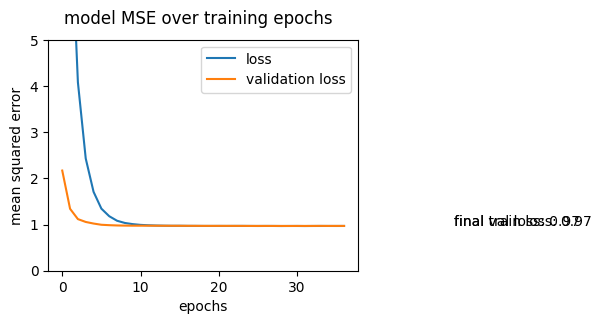

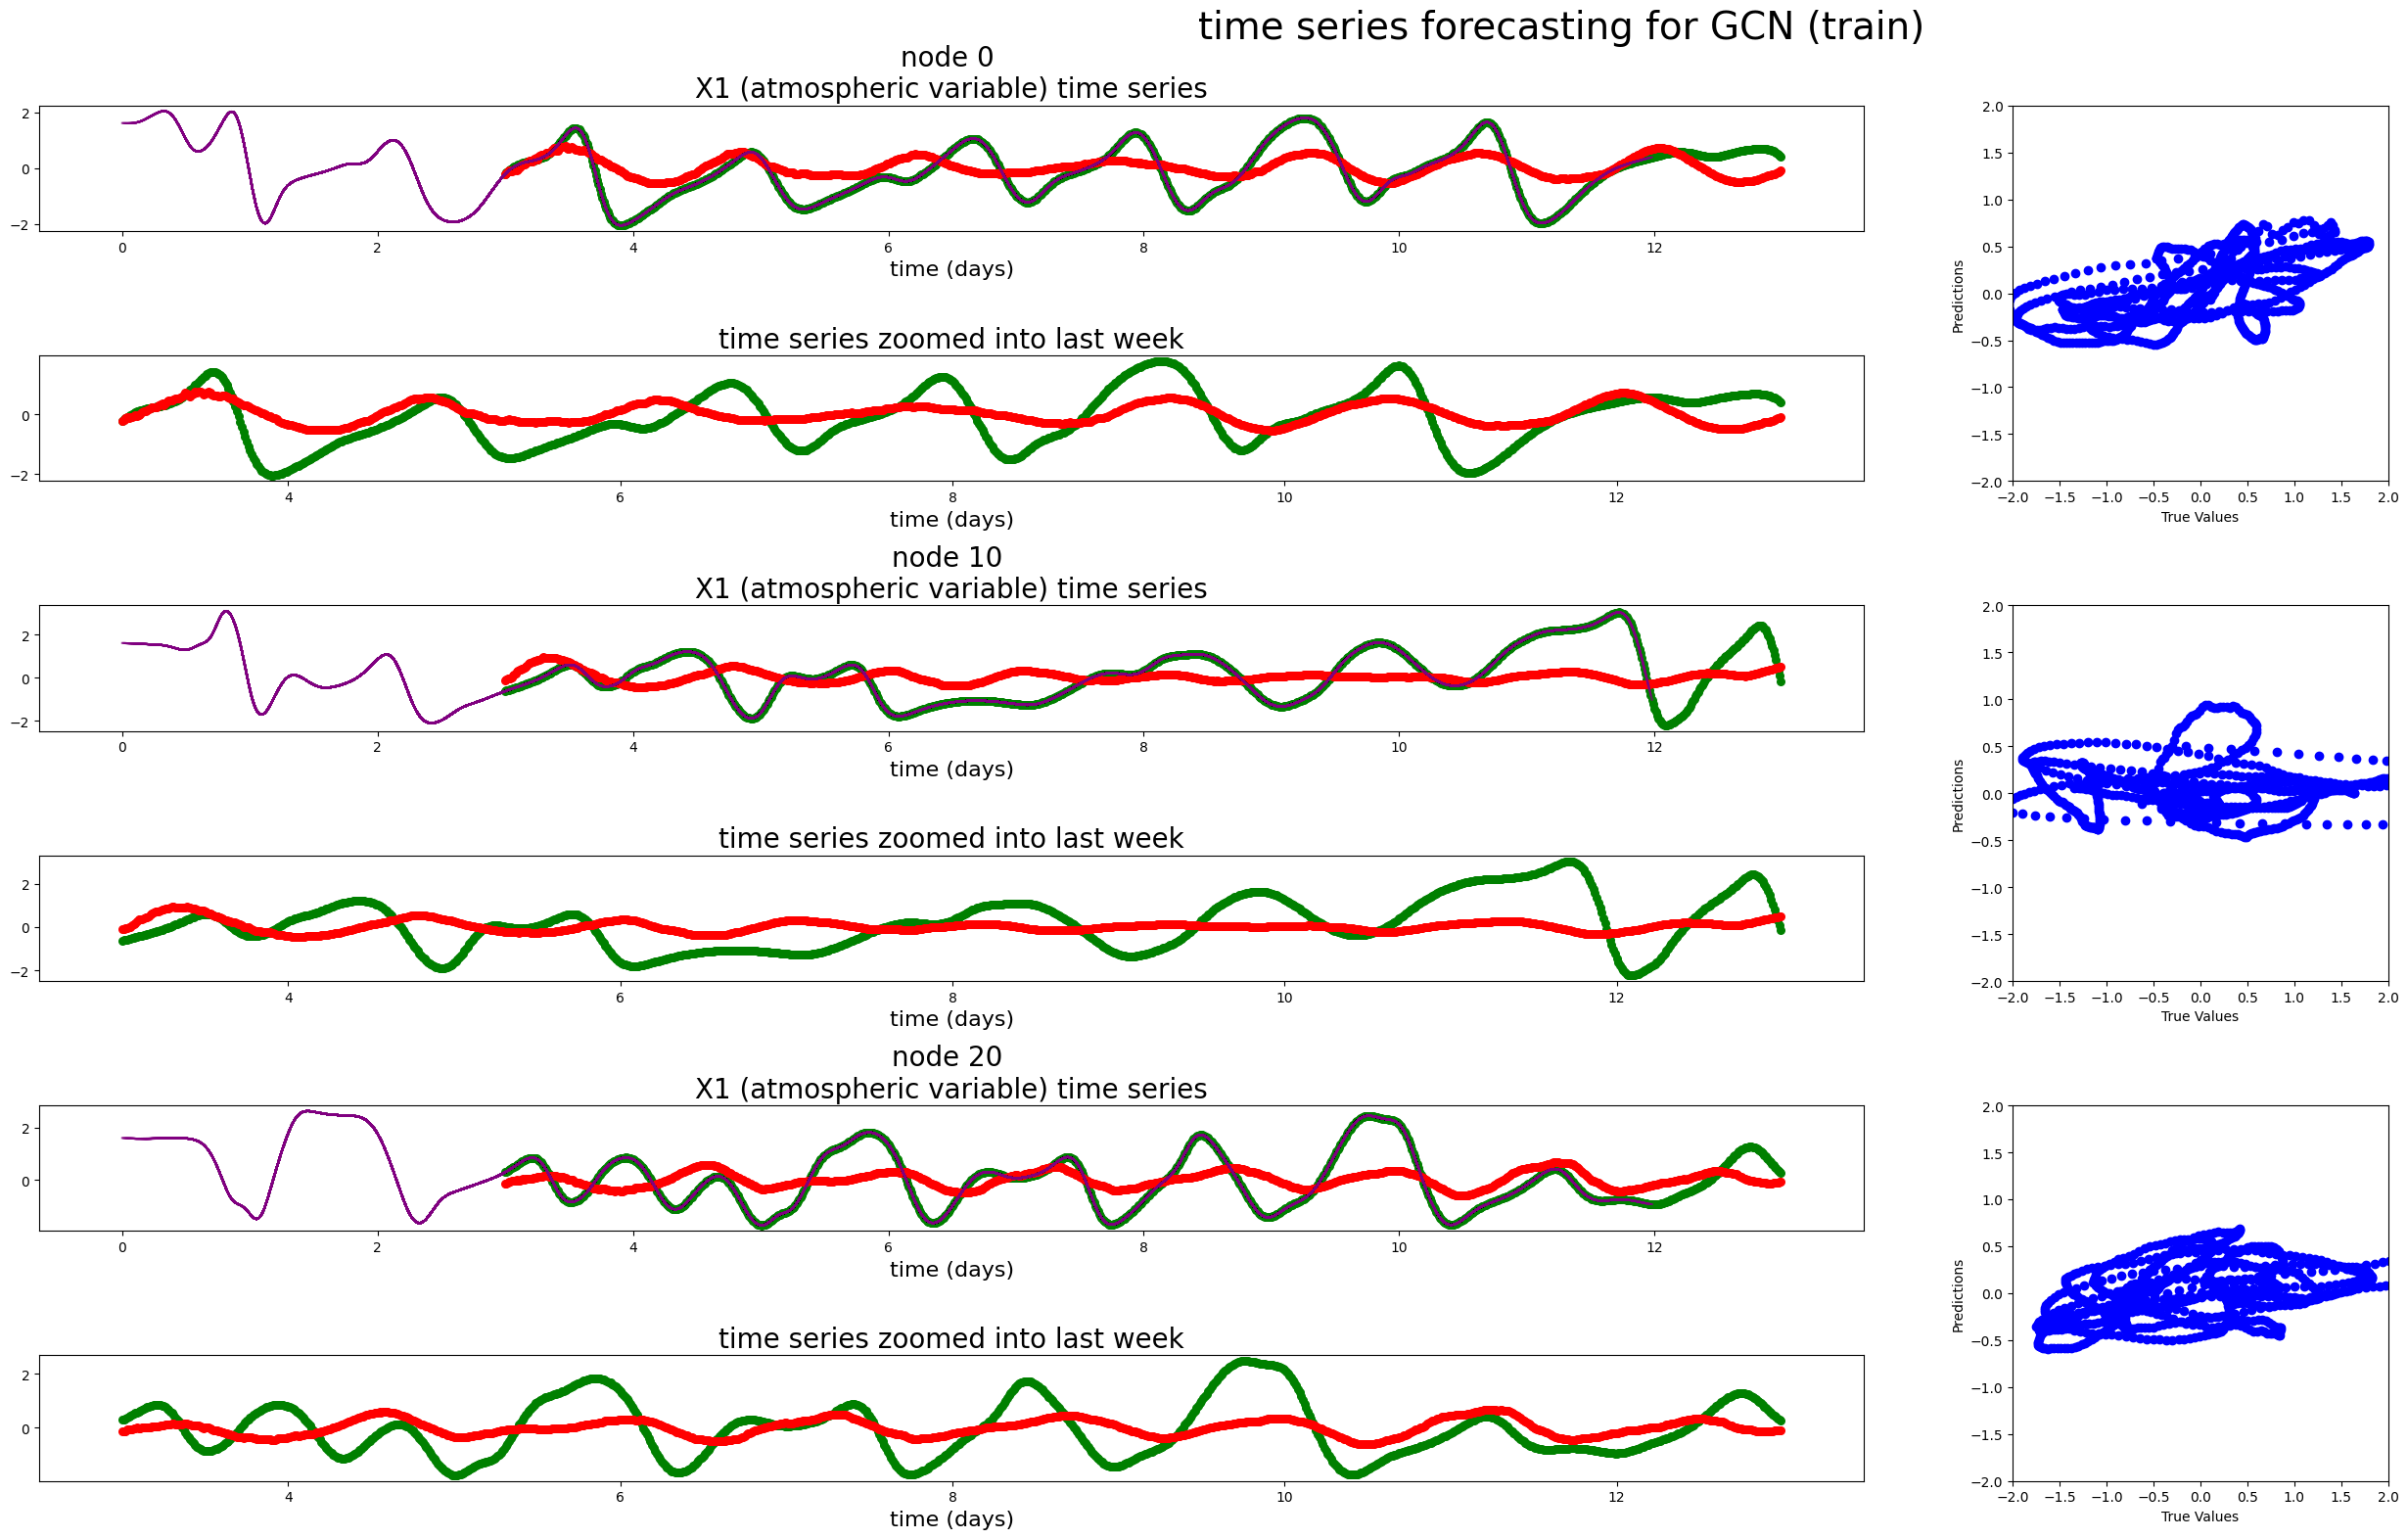

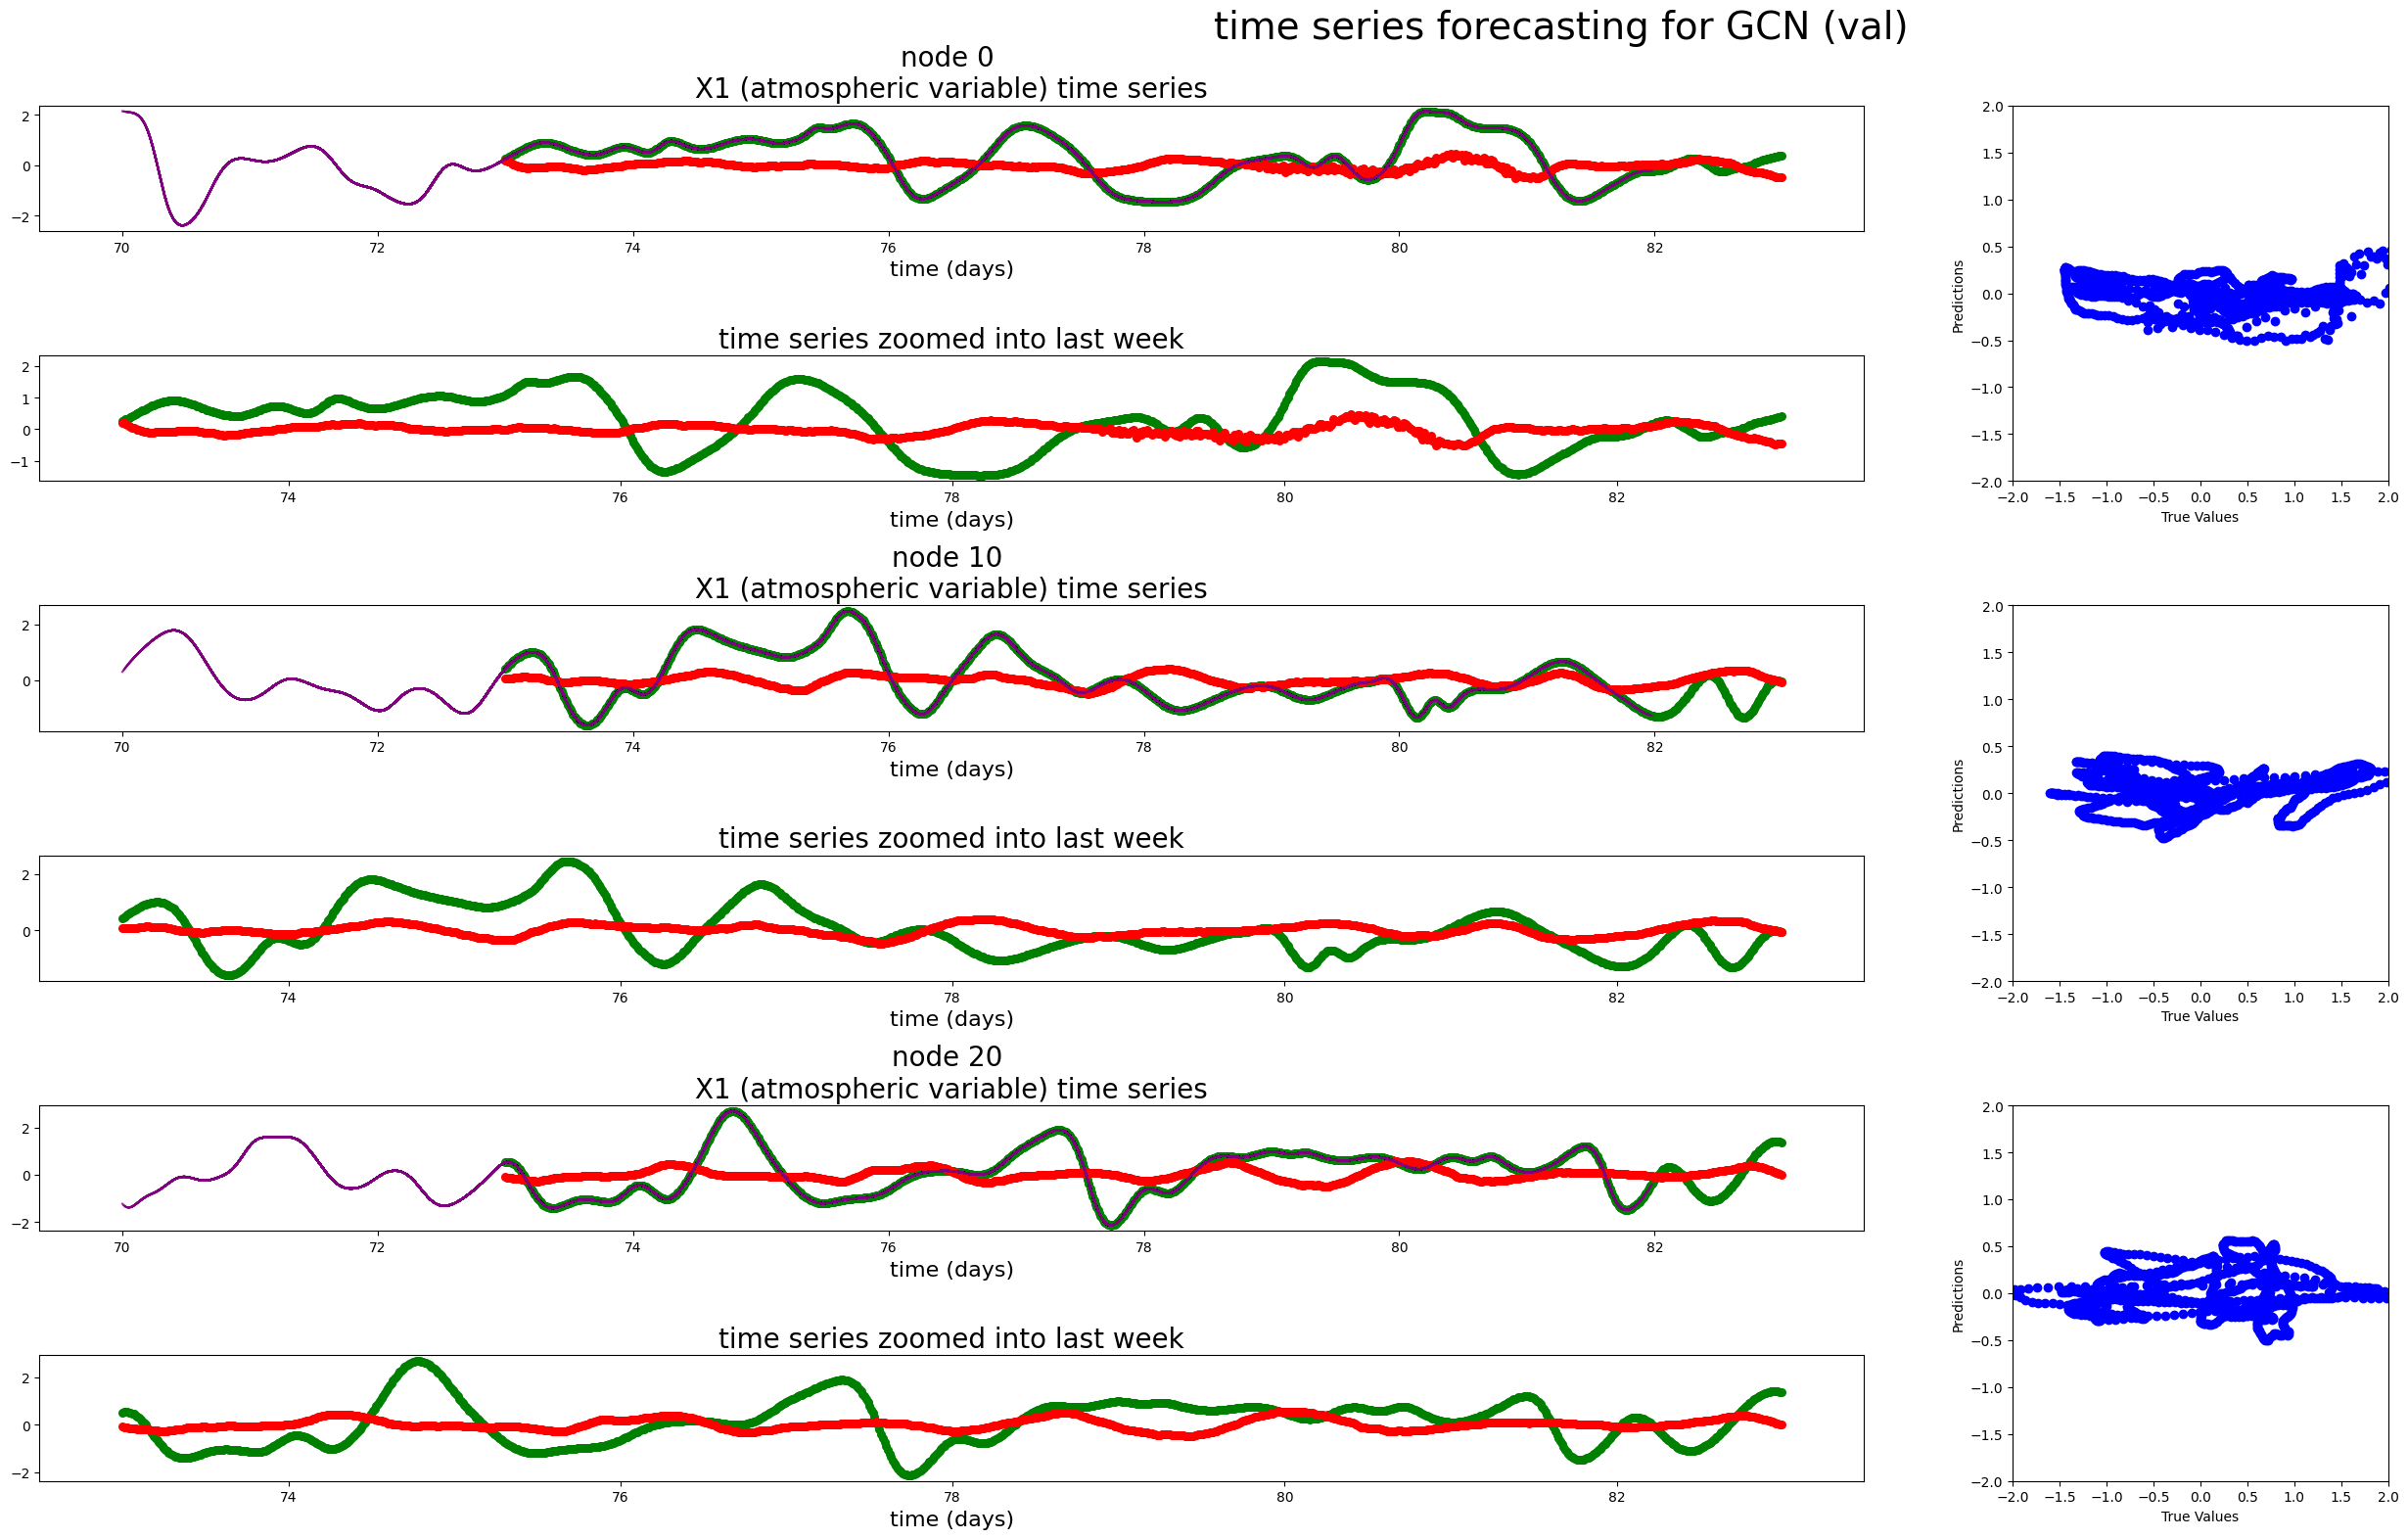

In [24]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(train[:1000],
                                                                  val[:1000],
                                                                  GCN_MSE,
                                                                  history_MSE,
                                                                  epochs=50,
                                                                  ylim=(0, 5))


We observe that the mean squared error encourages the model to predict all values close to 0. It seems like because much of our values are between -1 and 1, bad predictions are not strongly penalized by the square of the error.

### root mean squared error

In [22]:
GCN_RMSE, history_RMSE, fname_RMSE = make_train_GCN(train,
                                                    val,
                                                    loss=RootMeanSquaredError(),
                                                    activation="relu",
                                                    epochs=5,
                                                    eval_val=True,
                                                    early_stopping=True)


Epoch 1/5
219/219 [==============================] - 15s 65ms/step - loss: 6.9143 - root_mean_squared_error: 4.5222 - val_loss: 0.9966 - val_root_mean_squared_error: 0.9973
Epoch 2/5
219/219 [==============================] - 3s 14ms/step - loss: 0.9873 - root_mean_squared_error: 0.9950 - val_loss: 1.0029 - val_root_mean_squared_error: 0.9999
Epoch 3/5
219/219 [==============================] - 3s 15ms/step - loss: 0.9829 - root_mean_squared_error: 0.9937 - val_loss: 1.0052 - val_root_mean_squared_error: 0.9999
Epoch 4/5
219/219 [==============================] - 3s 13ms/step - loss: 0.9829 - root_mean_squared_error: 0.9937 - val_loss: 1.0067 - val_root_mean_squared_error: 0.9999
Epoch 5/5
219/219 [==============================] - 2s 8ms/step - loss: 0.9829 - root_mean_squared_error: 0.9937 - val_loss: 1.0056 - val_root_mean_squared_error: 0.9999


32/32 [==============================] - 3s 94ms/step


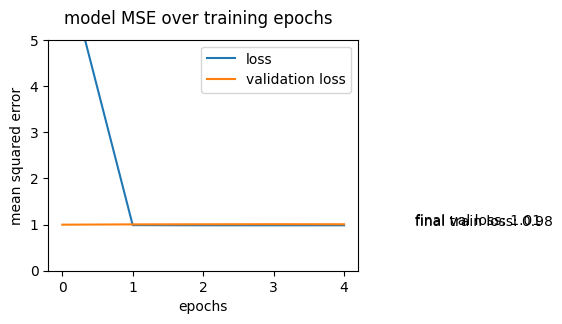

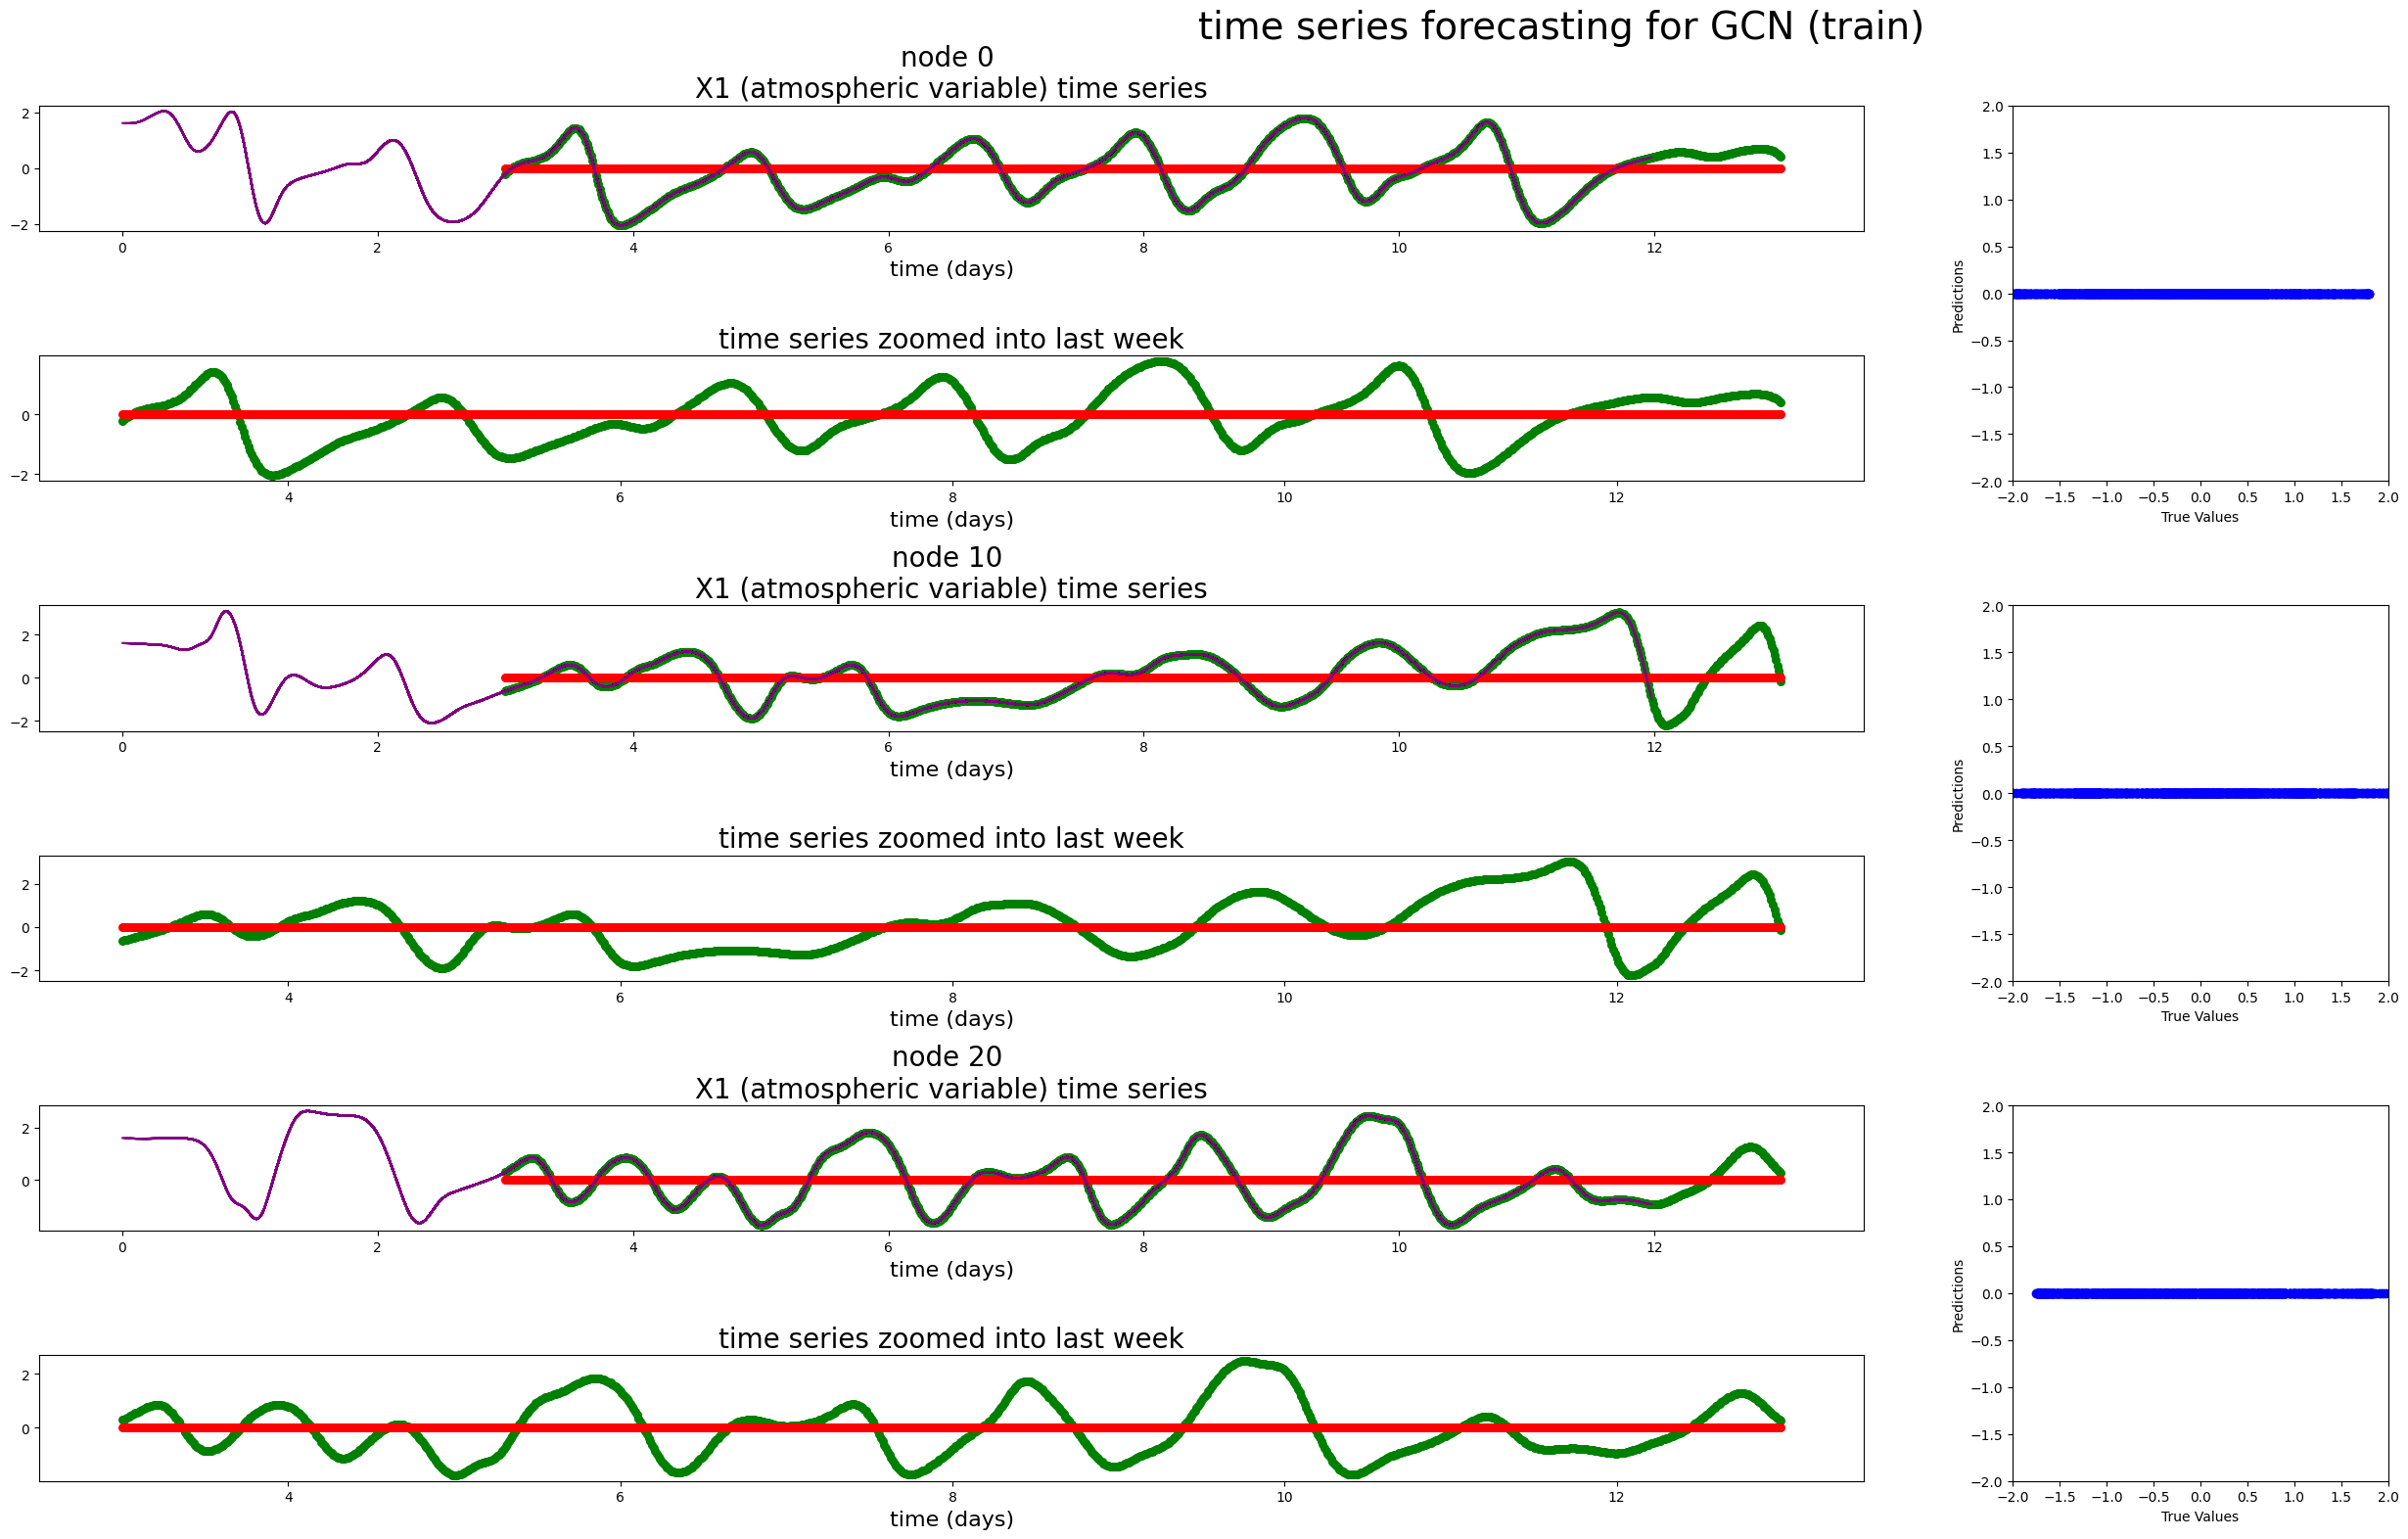

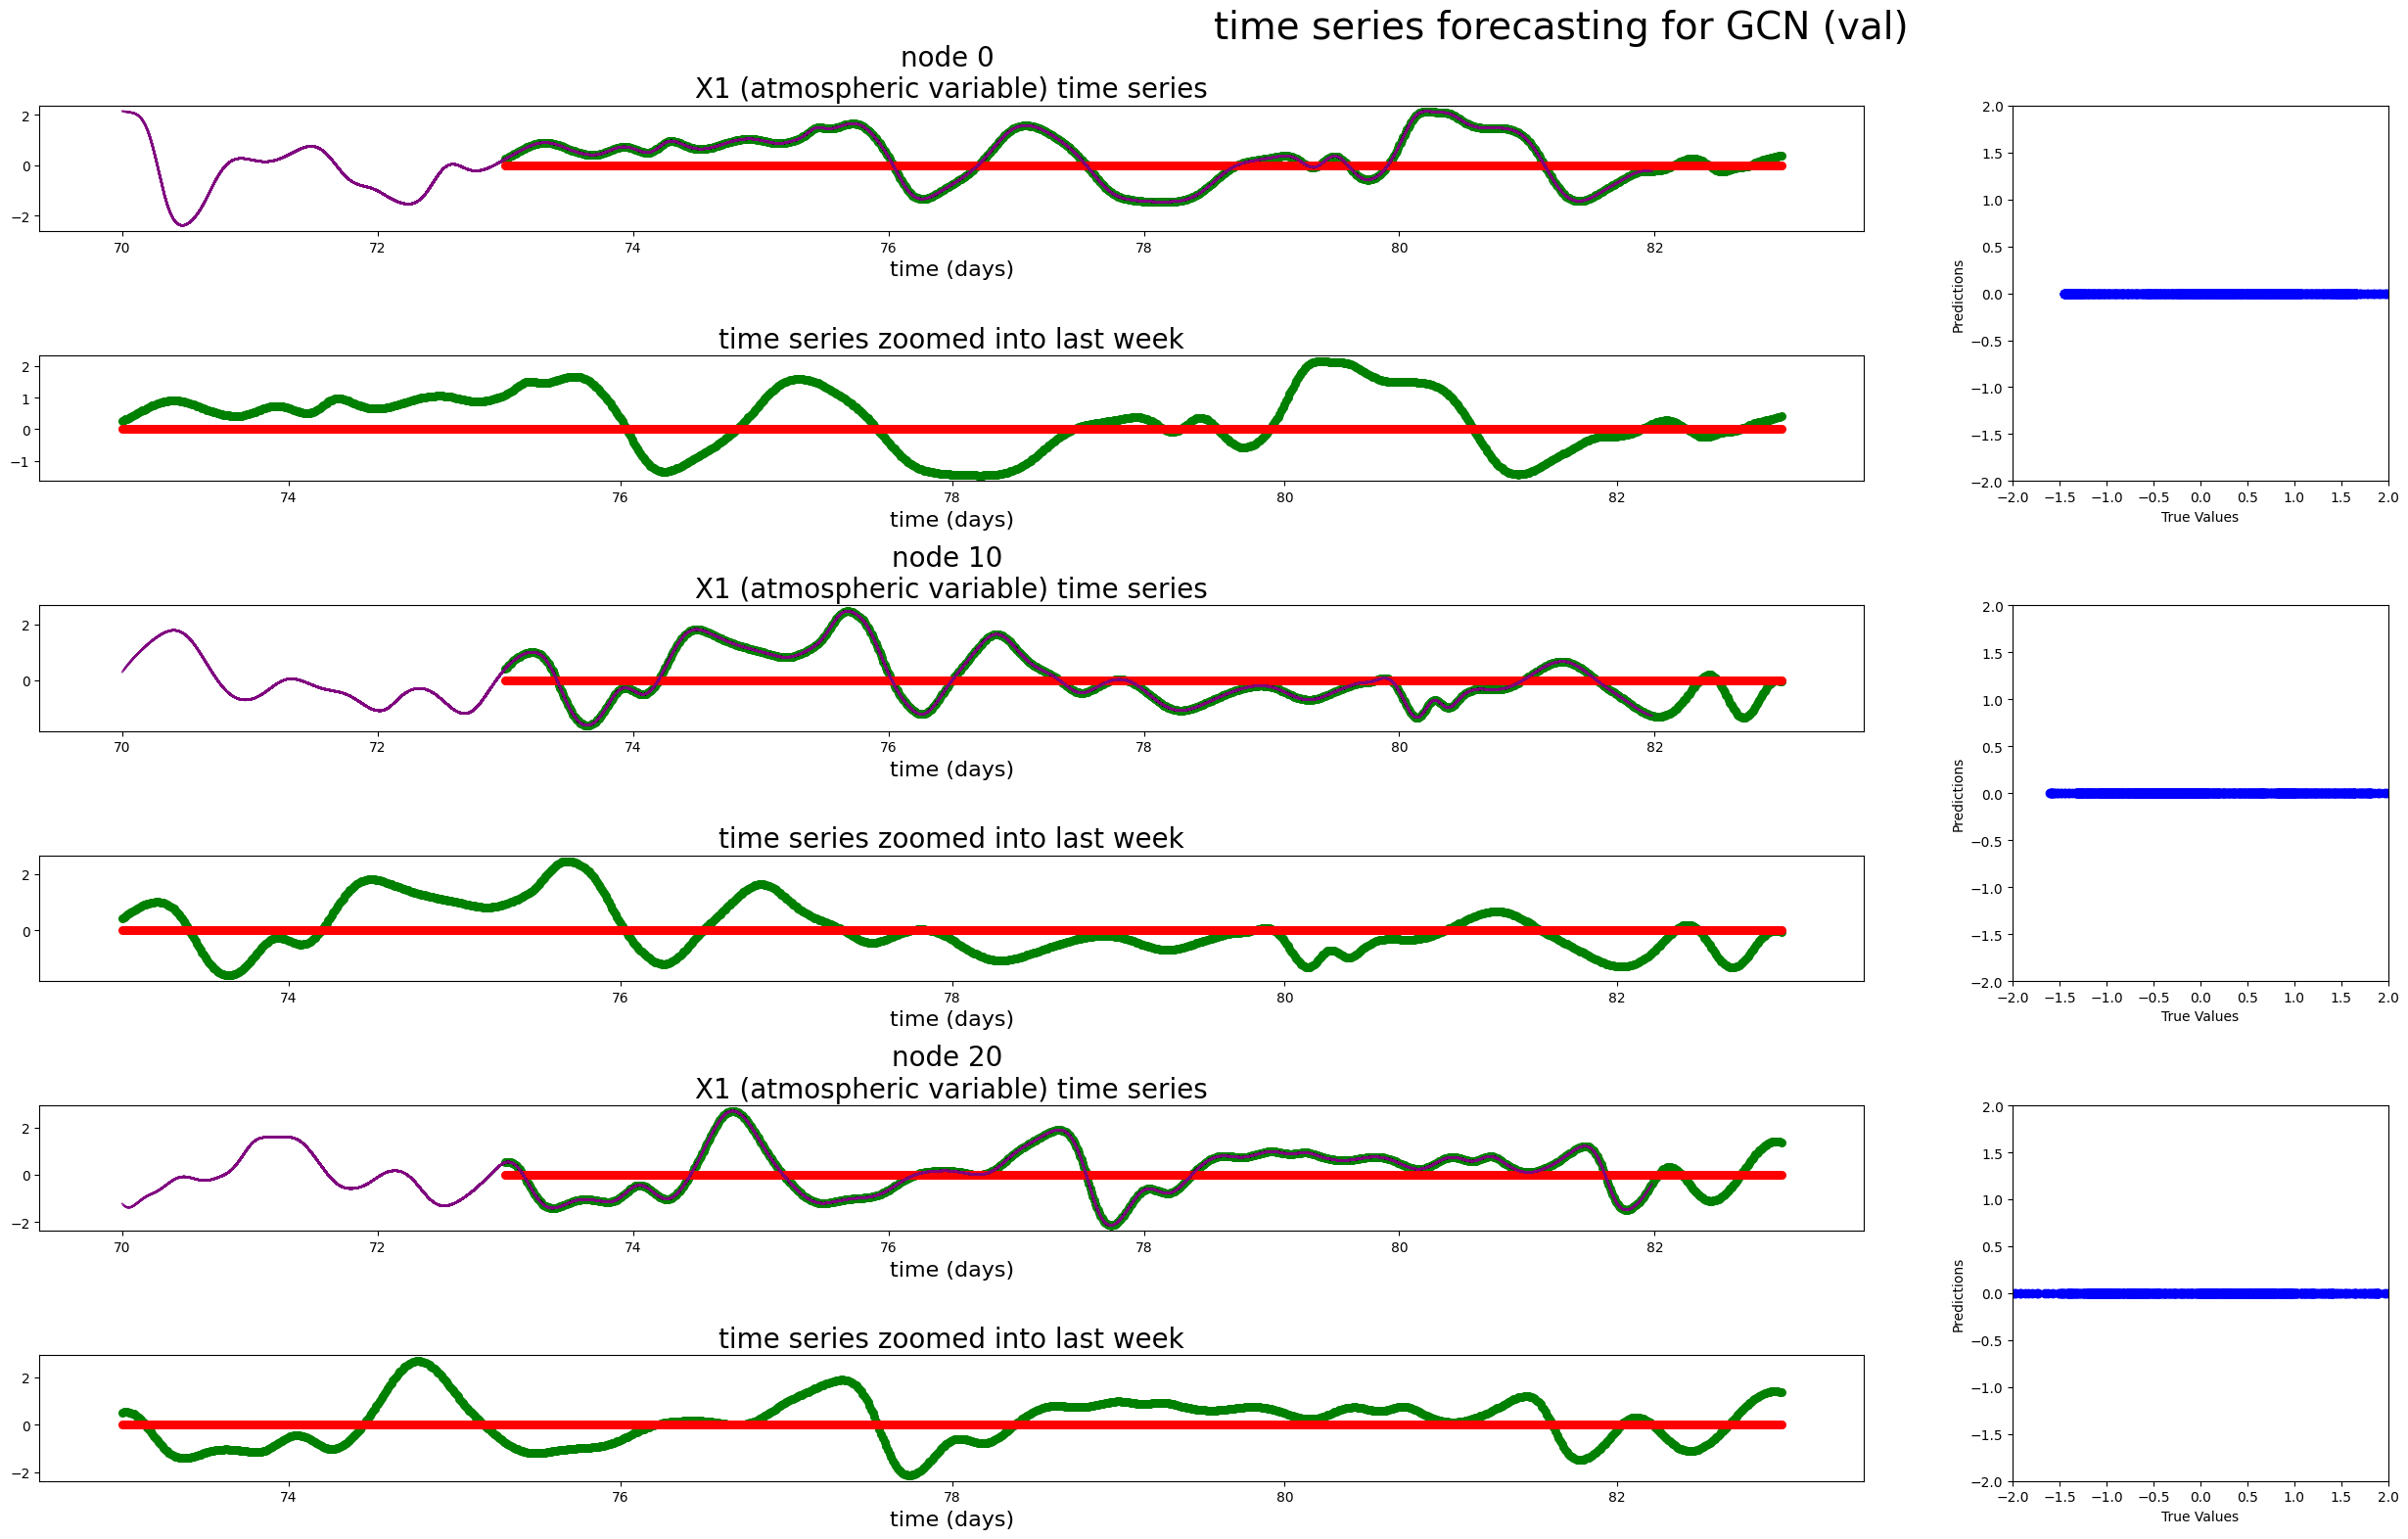

In [25]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000],
    val[:1000],
    GCN_RMSE,
    history_RMSE,
    epochs=5,
    ylim=(0, 5))


### mean absolute error

In [27]:
GCN_MAE, history_MAE, fname_MAE = make_train_GCN(
    train,
    val,
    loss='mean_absolute_error',
    activation="relu",
    epochs=15,
    eval_val=True,
    early_stopping=True,
    early_stopping_patience=3,
    early_stopping_start_from_epoch=10,
    verbose=0)


In [28]:
# TODO: fix plot labels/title (change to loss not MSE)

32/32 [==============================] - 0s 5ms/step


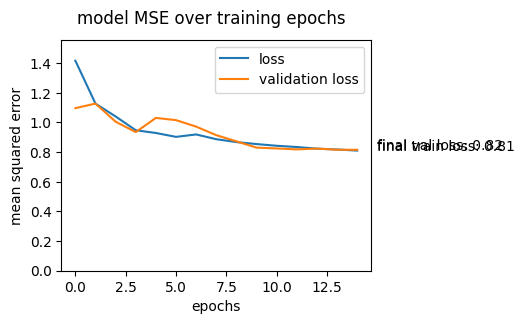

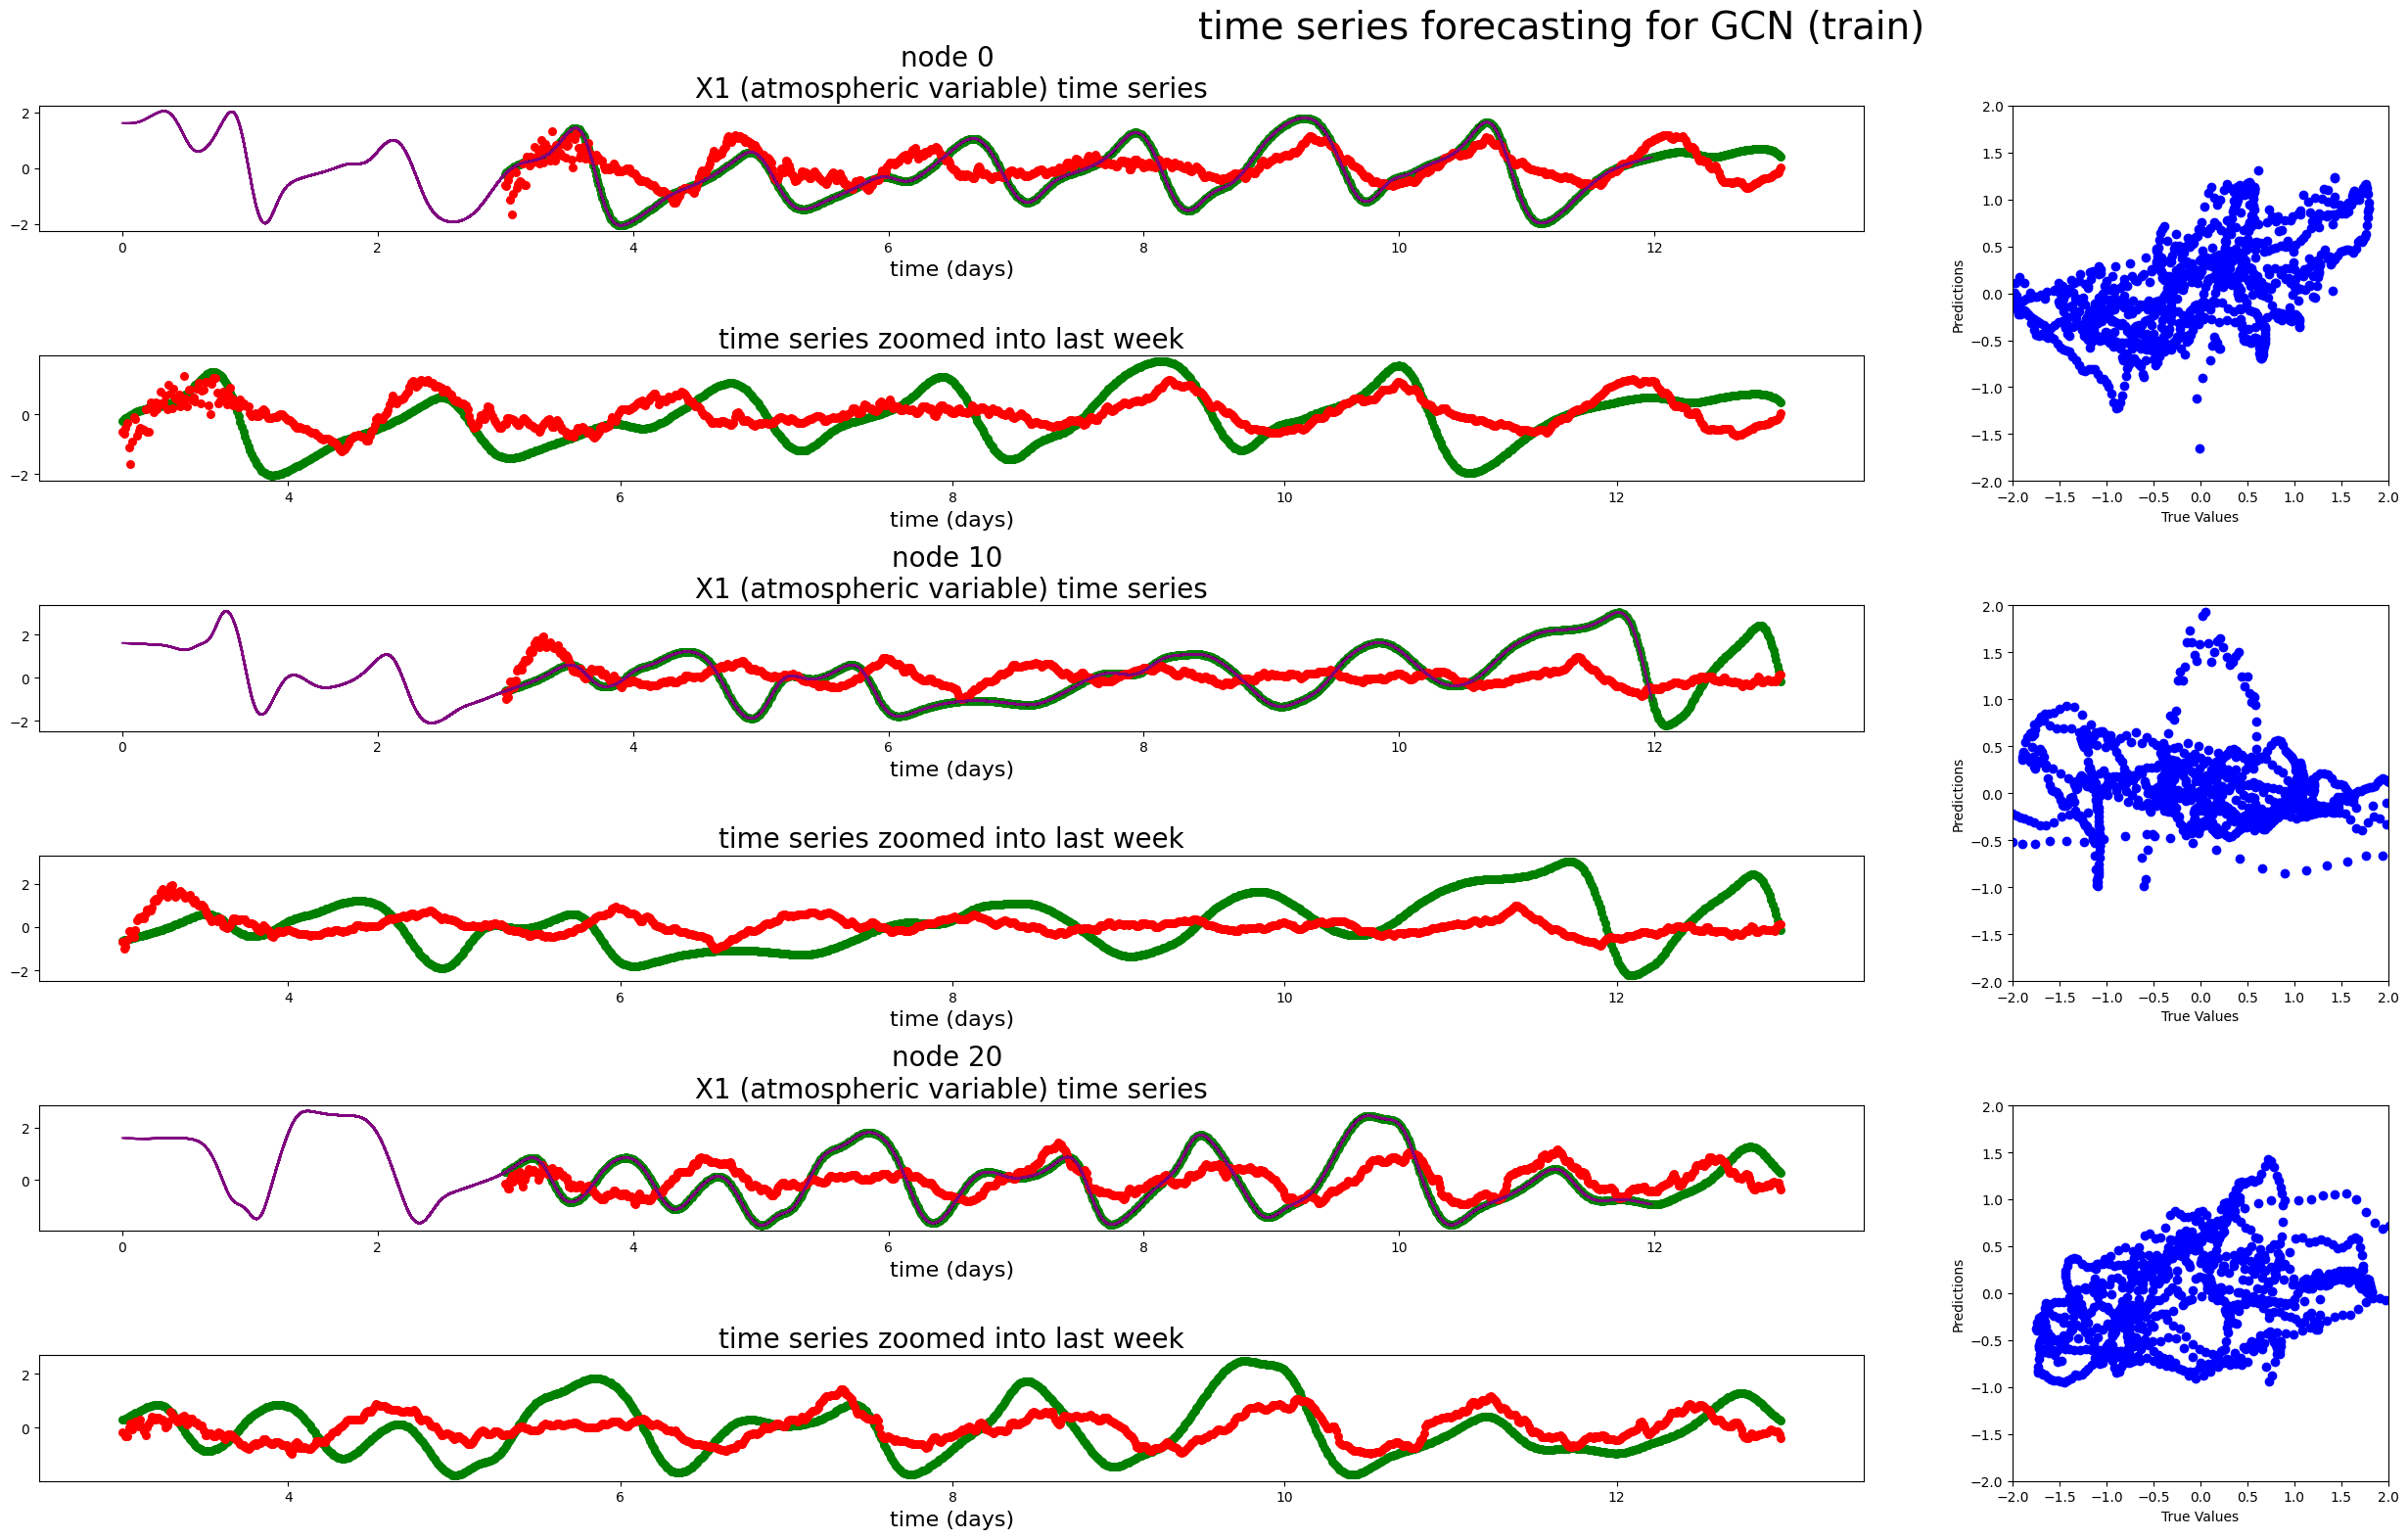

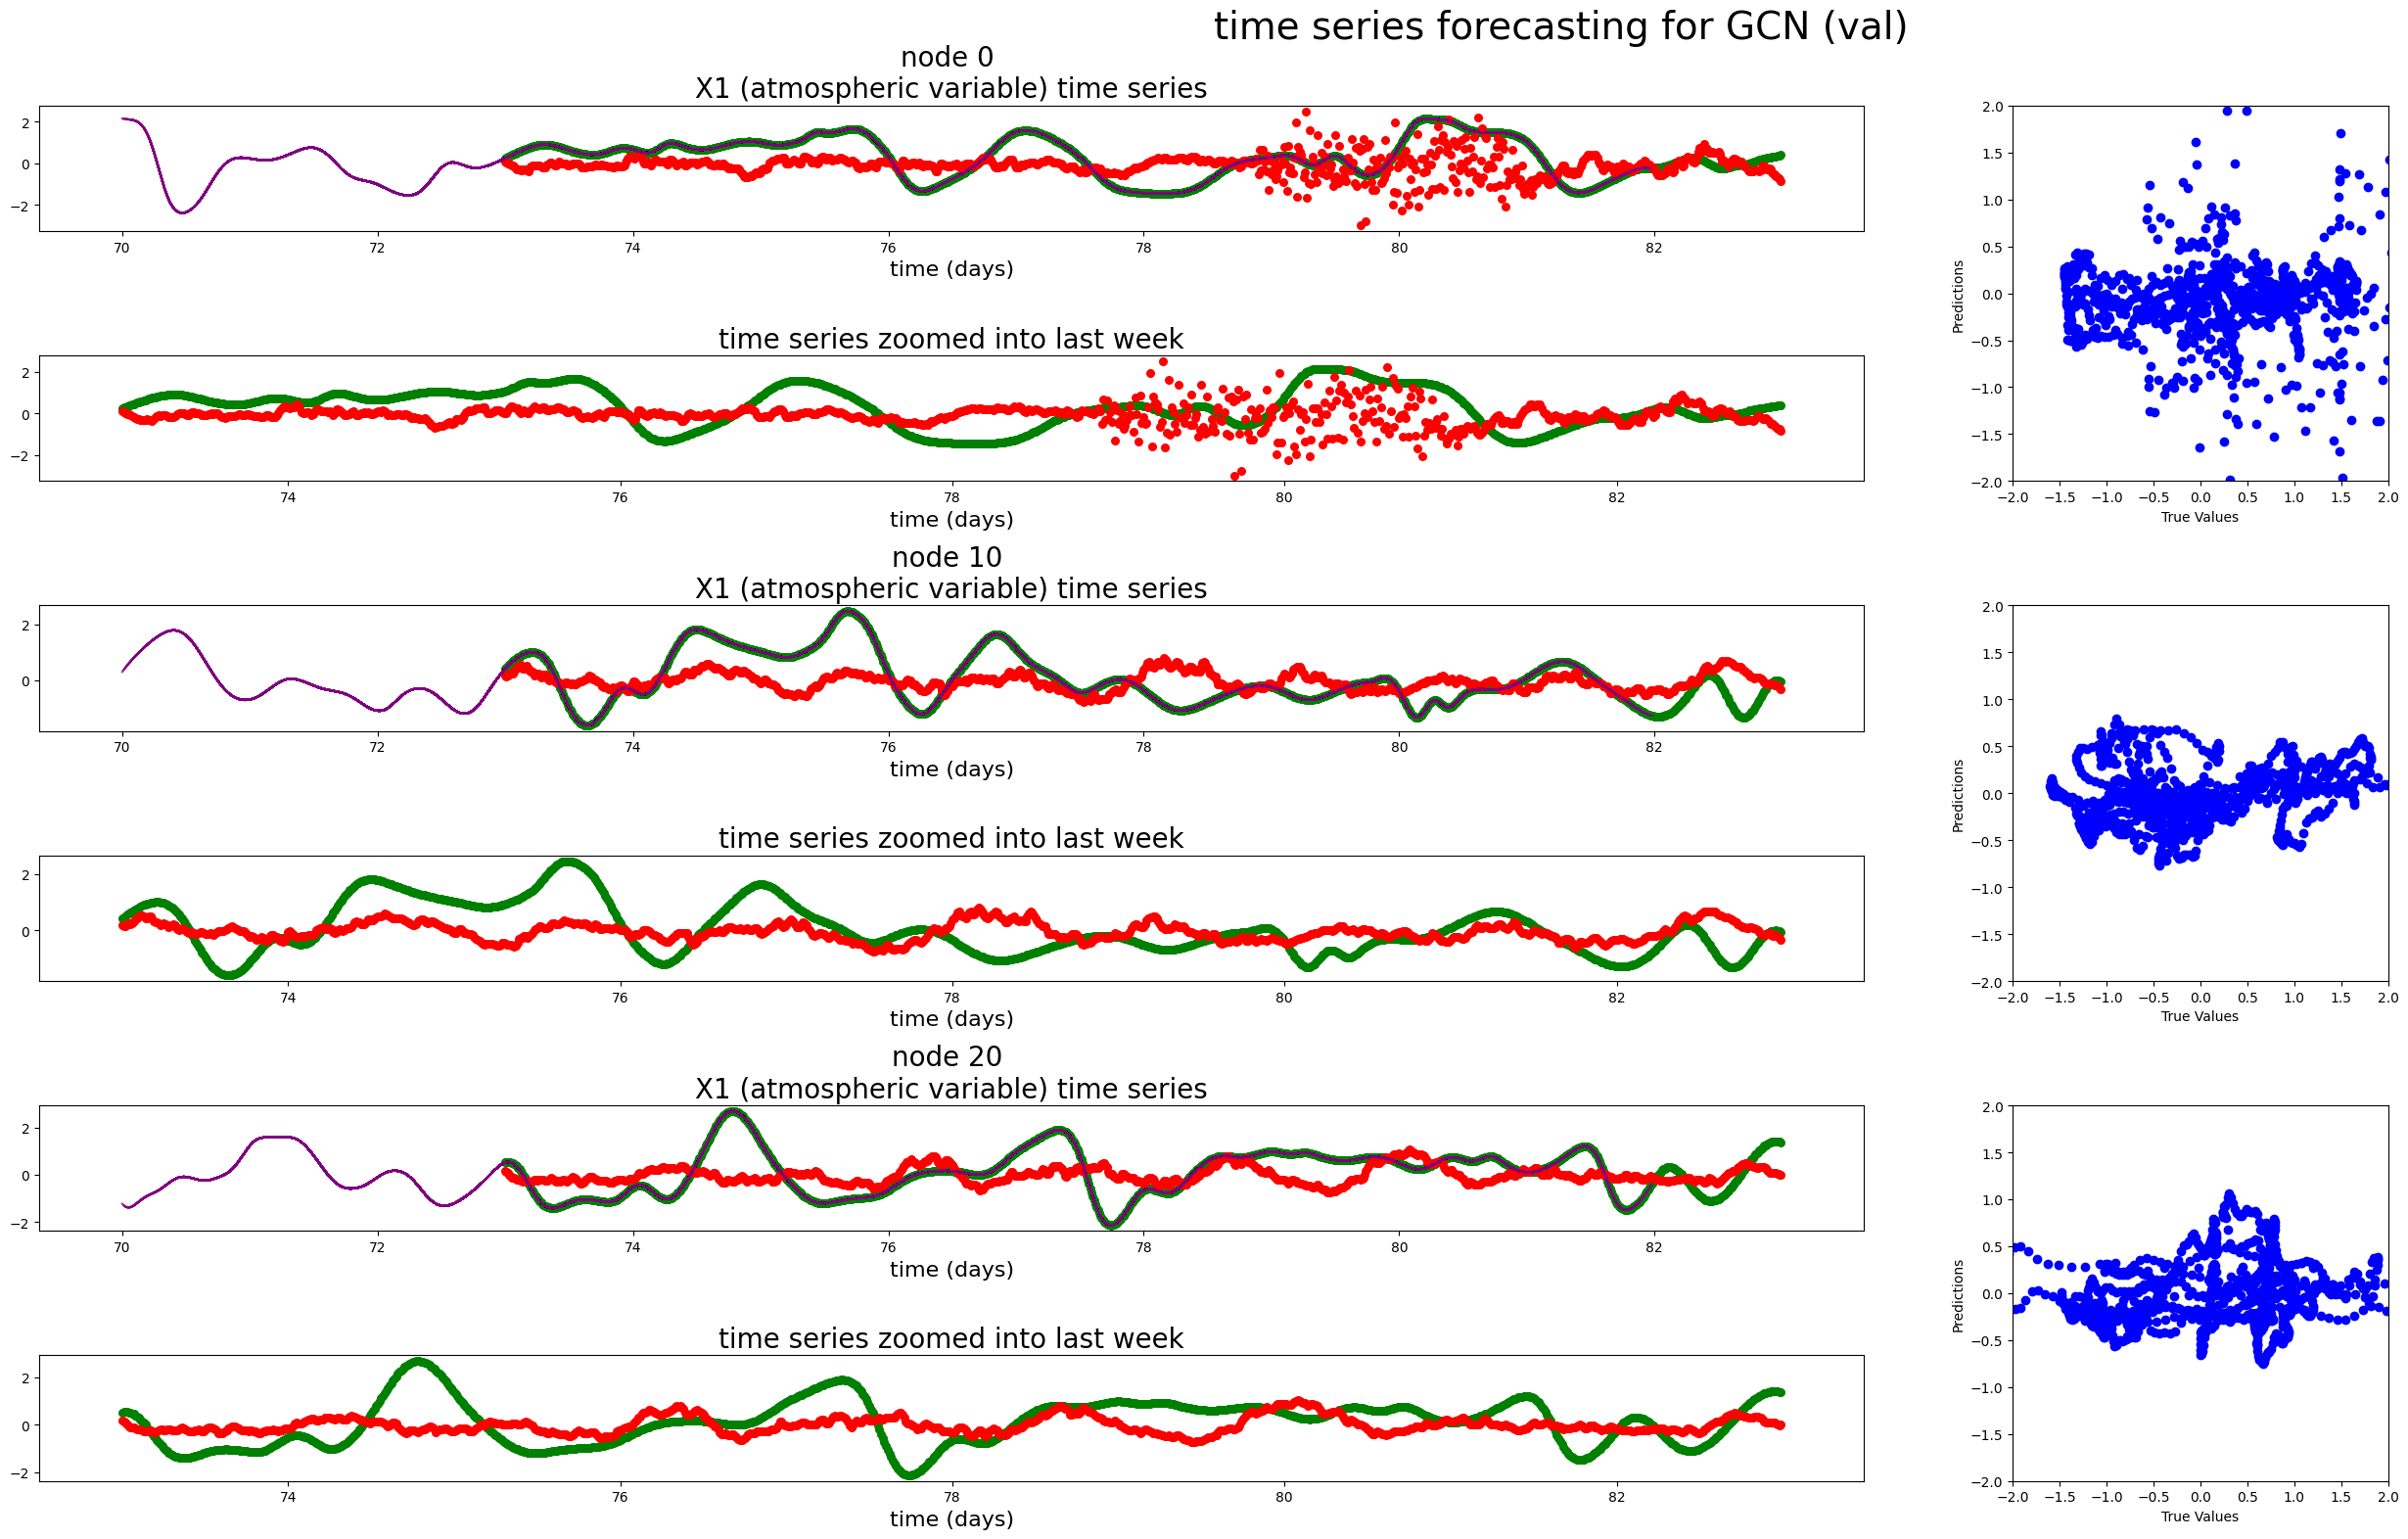

In [29]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(train[:1000],
                                                                  val[:1000],
                                                                  GCN_MAE,
                                                                  history_MAE,
                                                                  epochs=15)


### Mean Absolute Percentage Error

In [27]:
GCN_MAPE, history_MAPE, fname_MAPE = make_train_GCN(
    train,
    val,
    loss=MeanAbsolutePercentageError(),
    activation="relu",
    epochs=50,
    eval_val=True,
    early_stopping=True,
    early_stopping_patience=10,
    early_stopping_start_from_epoch=30,
    verbose=0)


32/32 [==============================] - 0s 3ms/step


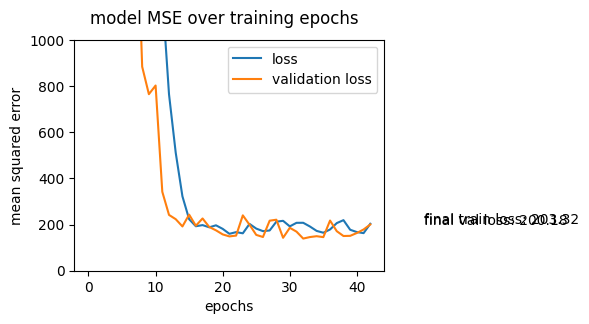

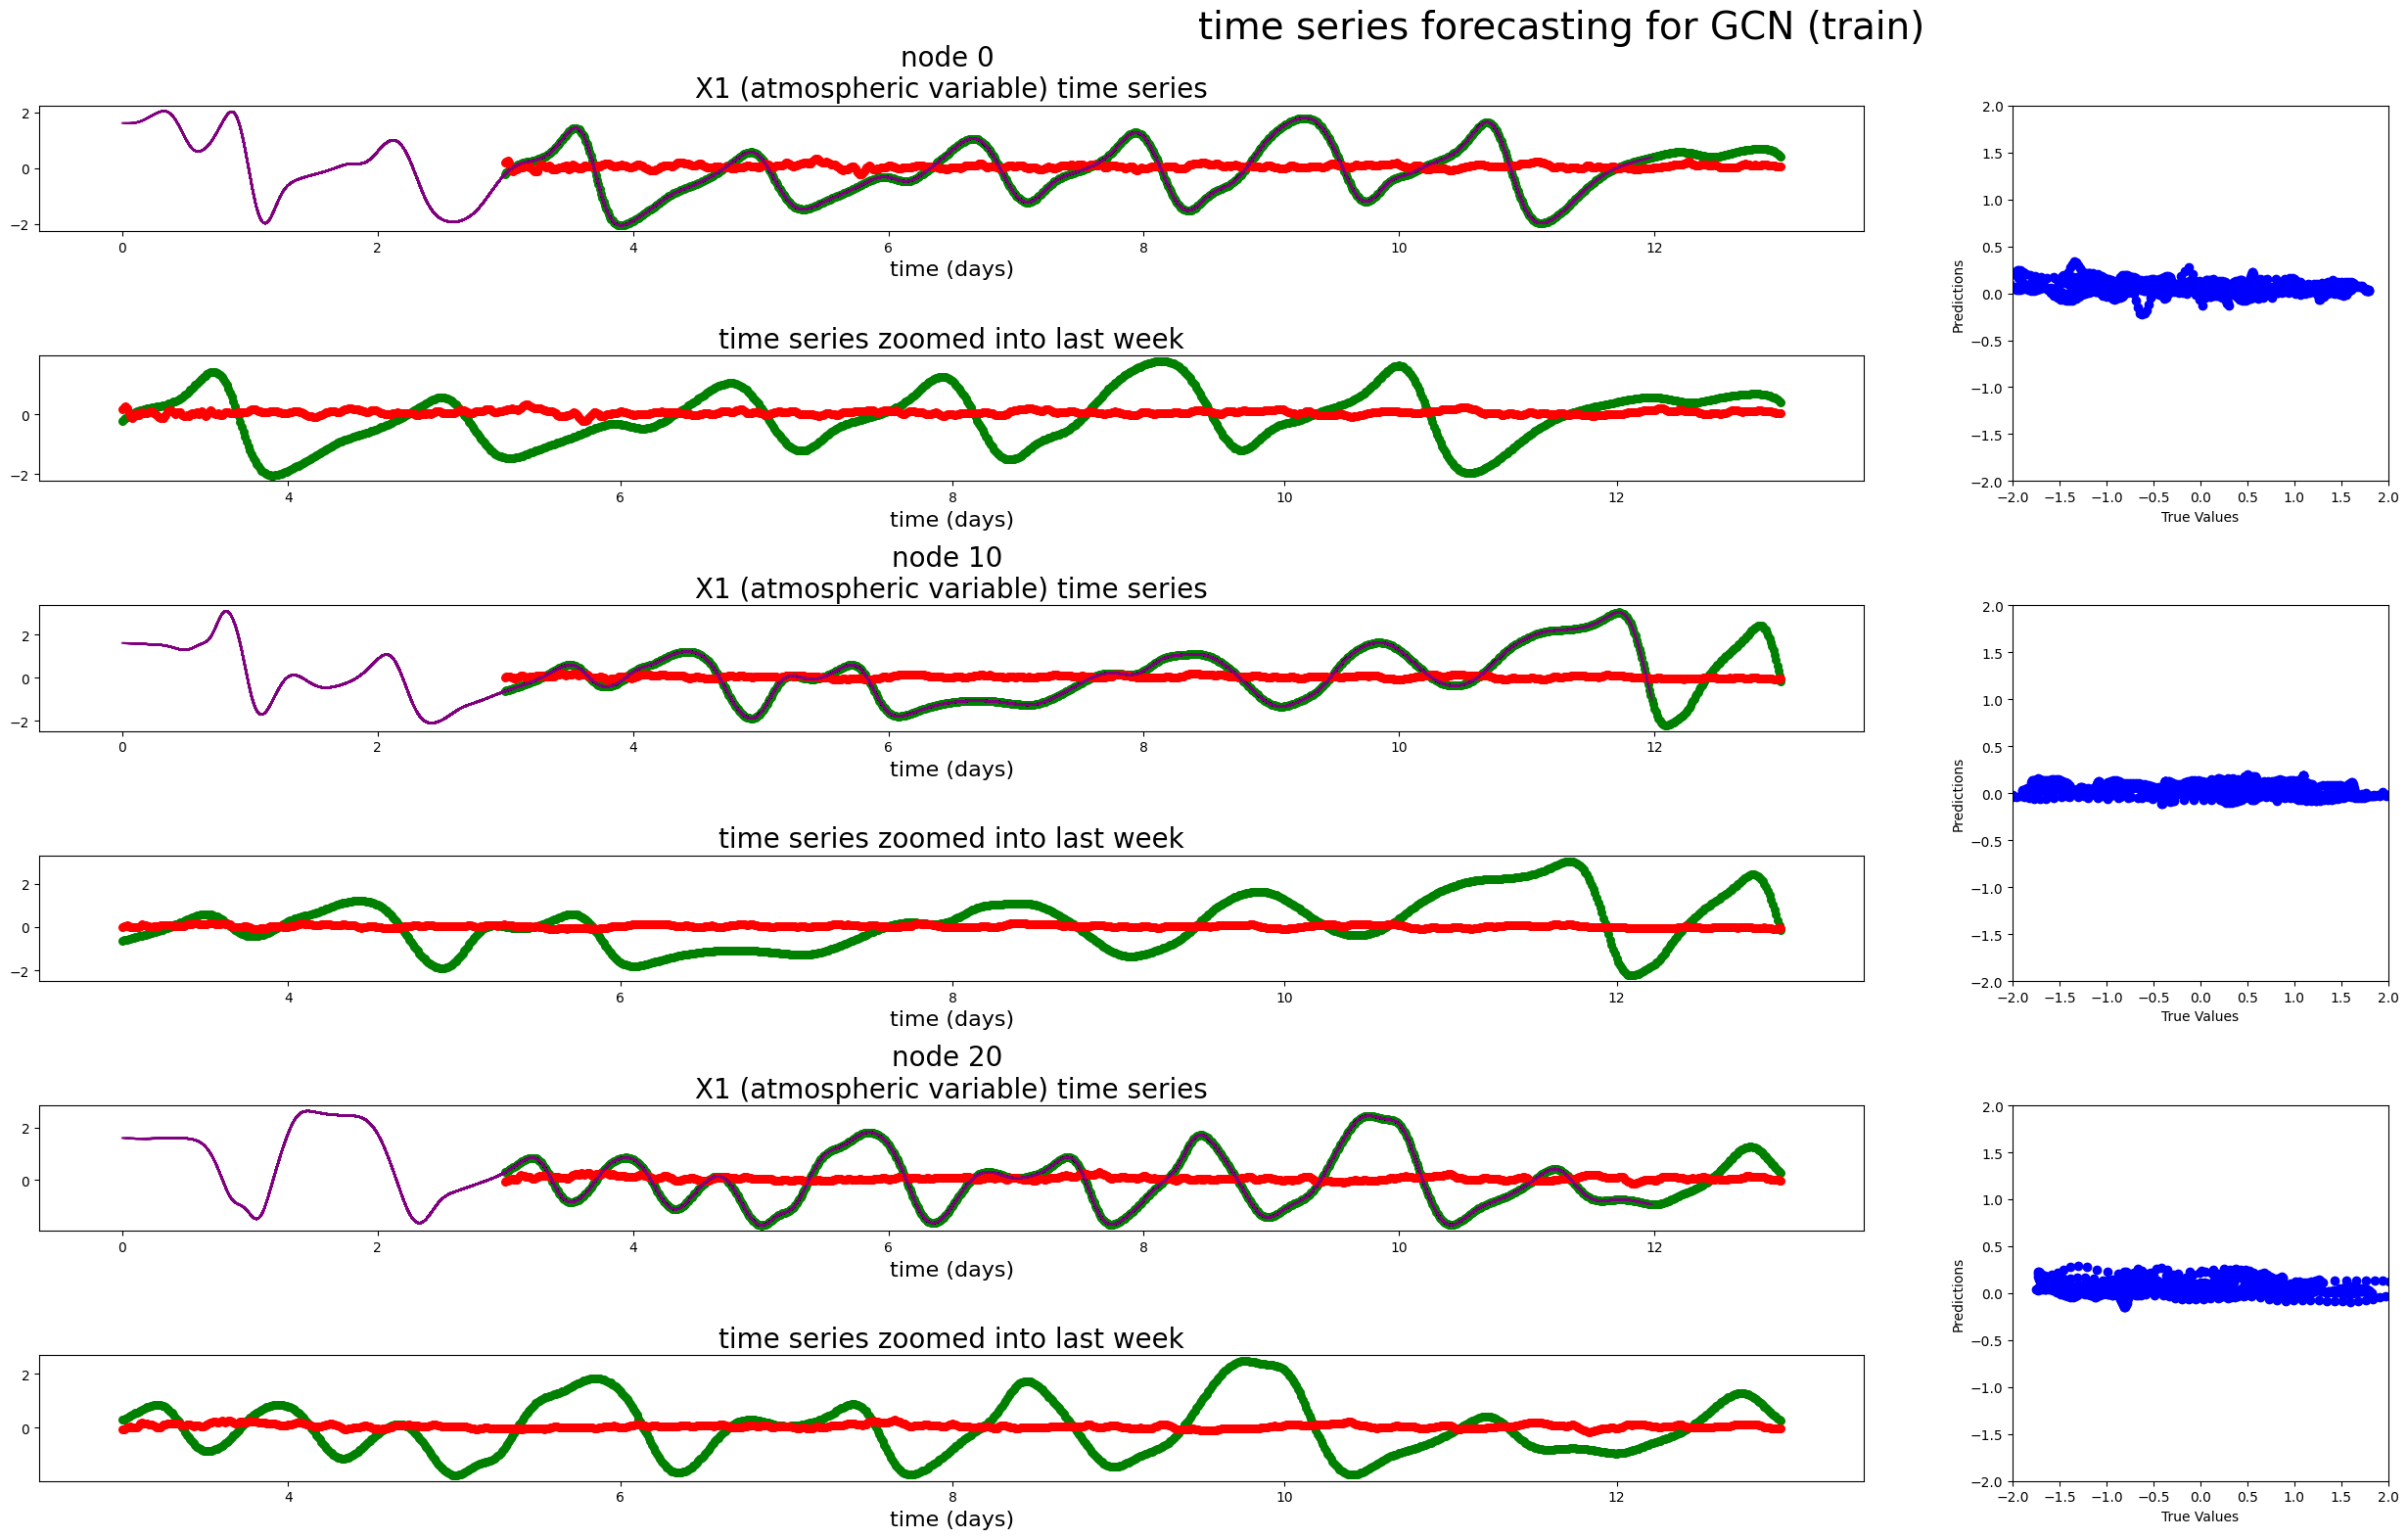

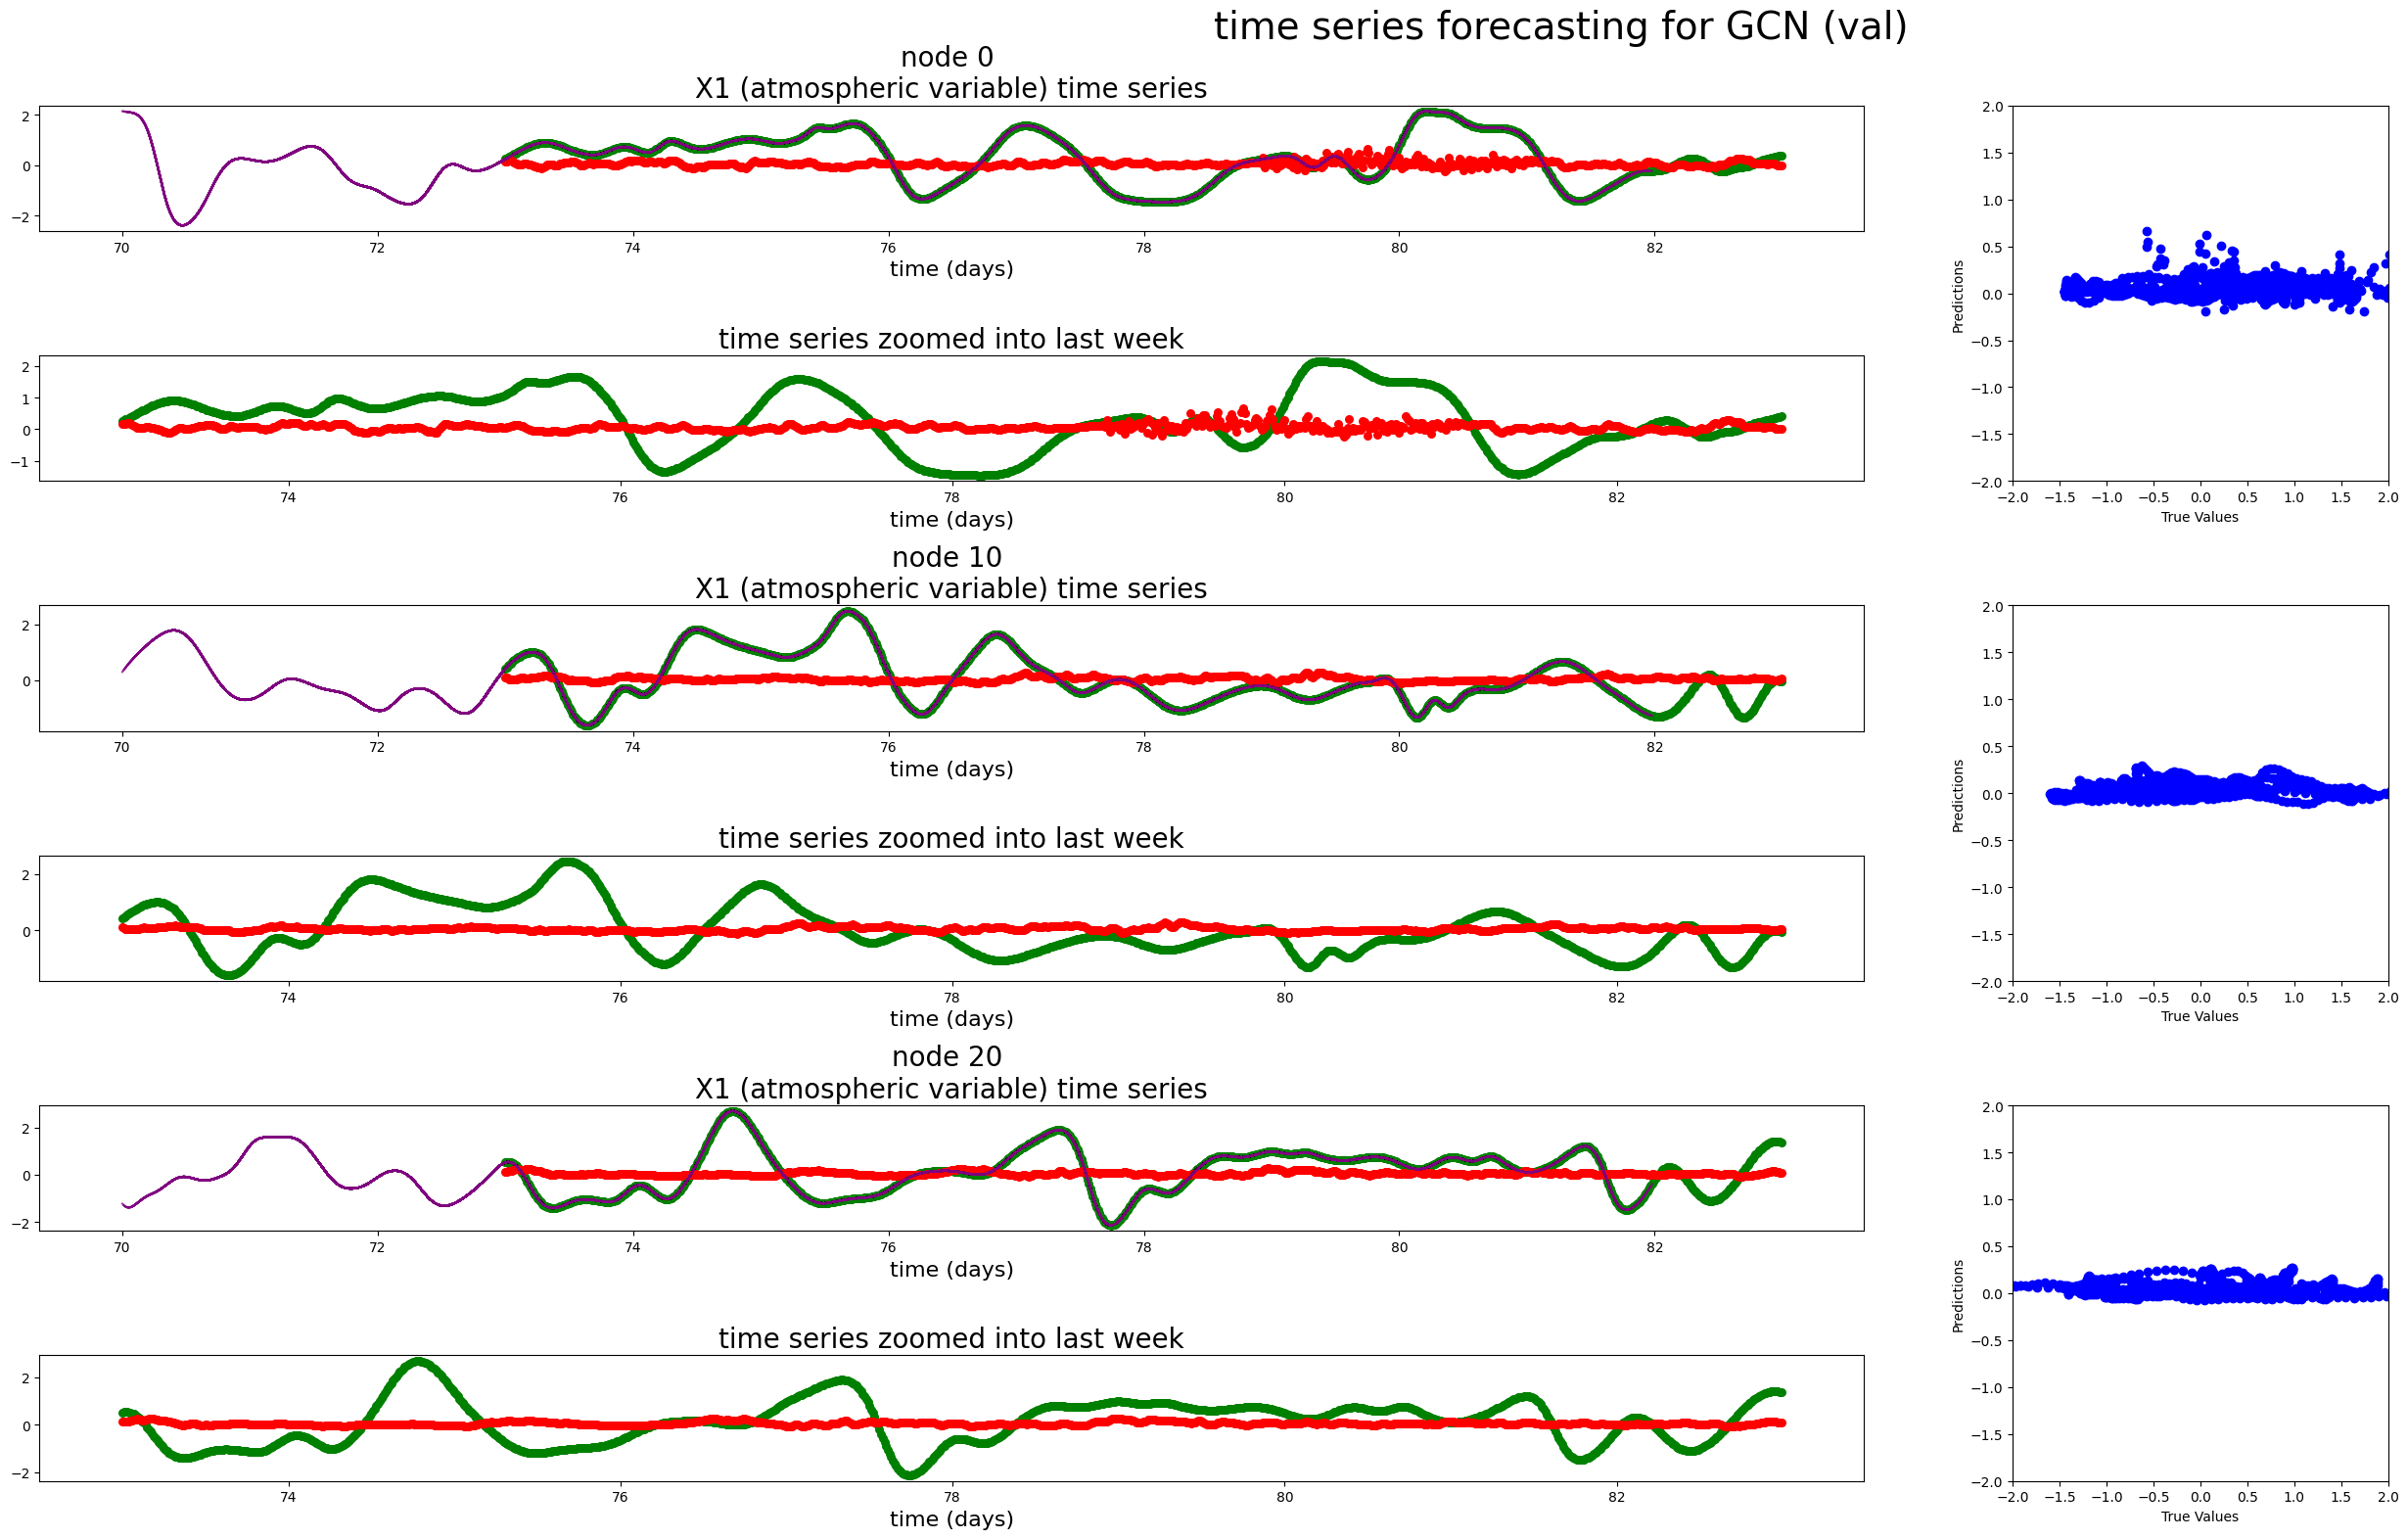

In [28]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000],
    val[:1000],
    GCN_MAPE,
    history_MAPE,
    epochs=50,
    ylim=(0, 1000))


If the model still predicts all 0s, we expect the absolute percentage loss to be 100 * (y_true - 0)/(y_true) = 100. Thus, we expect the loss to plateau around 100. If it goes below, then it is actually starting to learn something. 

Actually, when we zoom in we see that it plateaus around 200 even though its basically predicting all 0s. Why? 

### Mean Squared Logarithmic Error

In [11]:
GCN_MSLE, history_MSLE, fname_MSLE = make_train_GCN(
    train,
    val,
    loss=MeanSquaredLogarithmicError(),
    activation="relu",
    epochs=100,
    eval_val=True,
    early_stopping=False,
    early_stopping_patience=5,
    early_stopping_start_from_epoch=20,
    verbose=0)


32/32 [==============================] - 0s 4ms/step


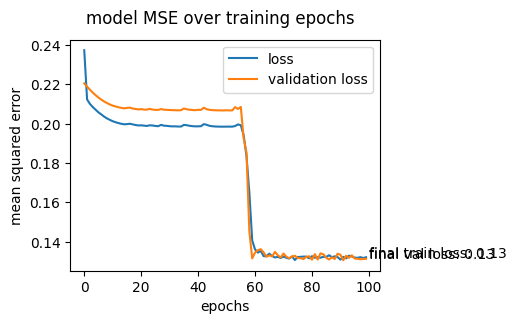

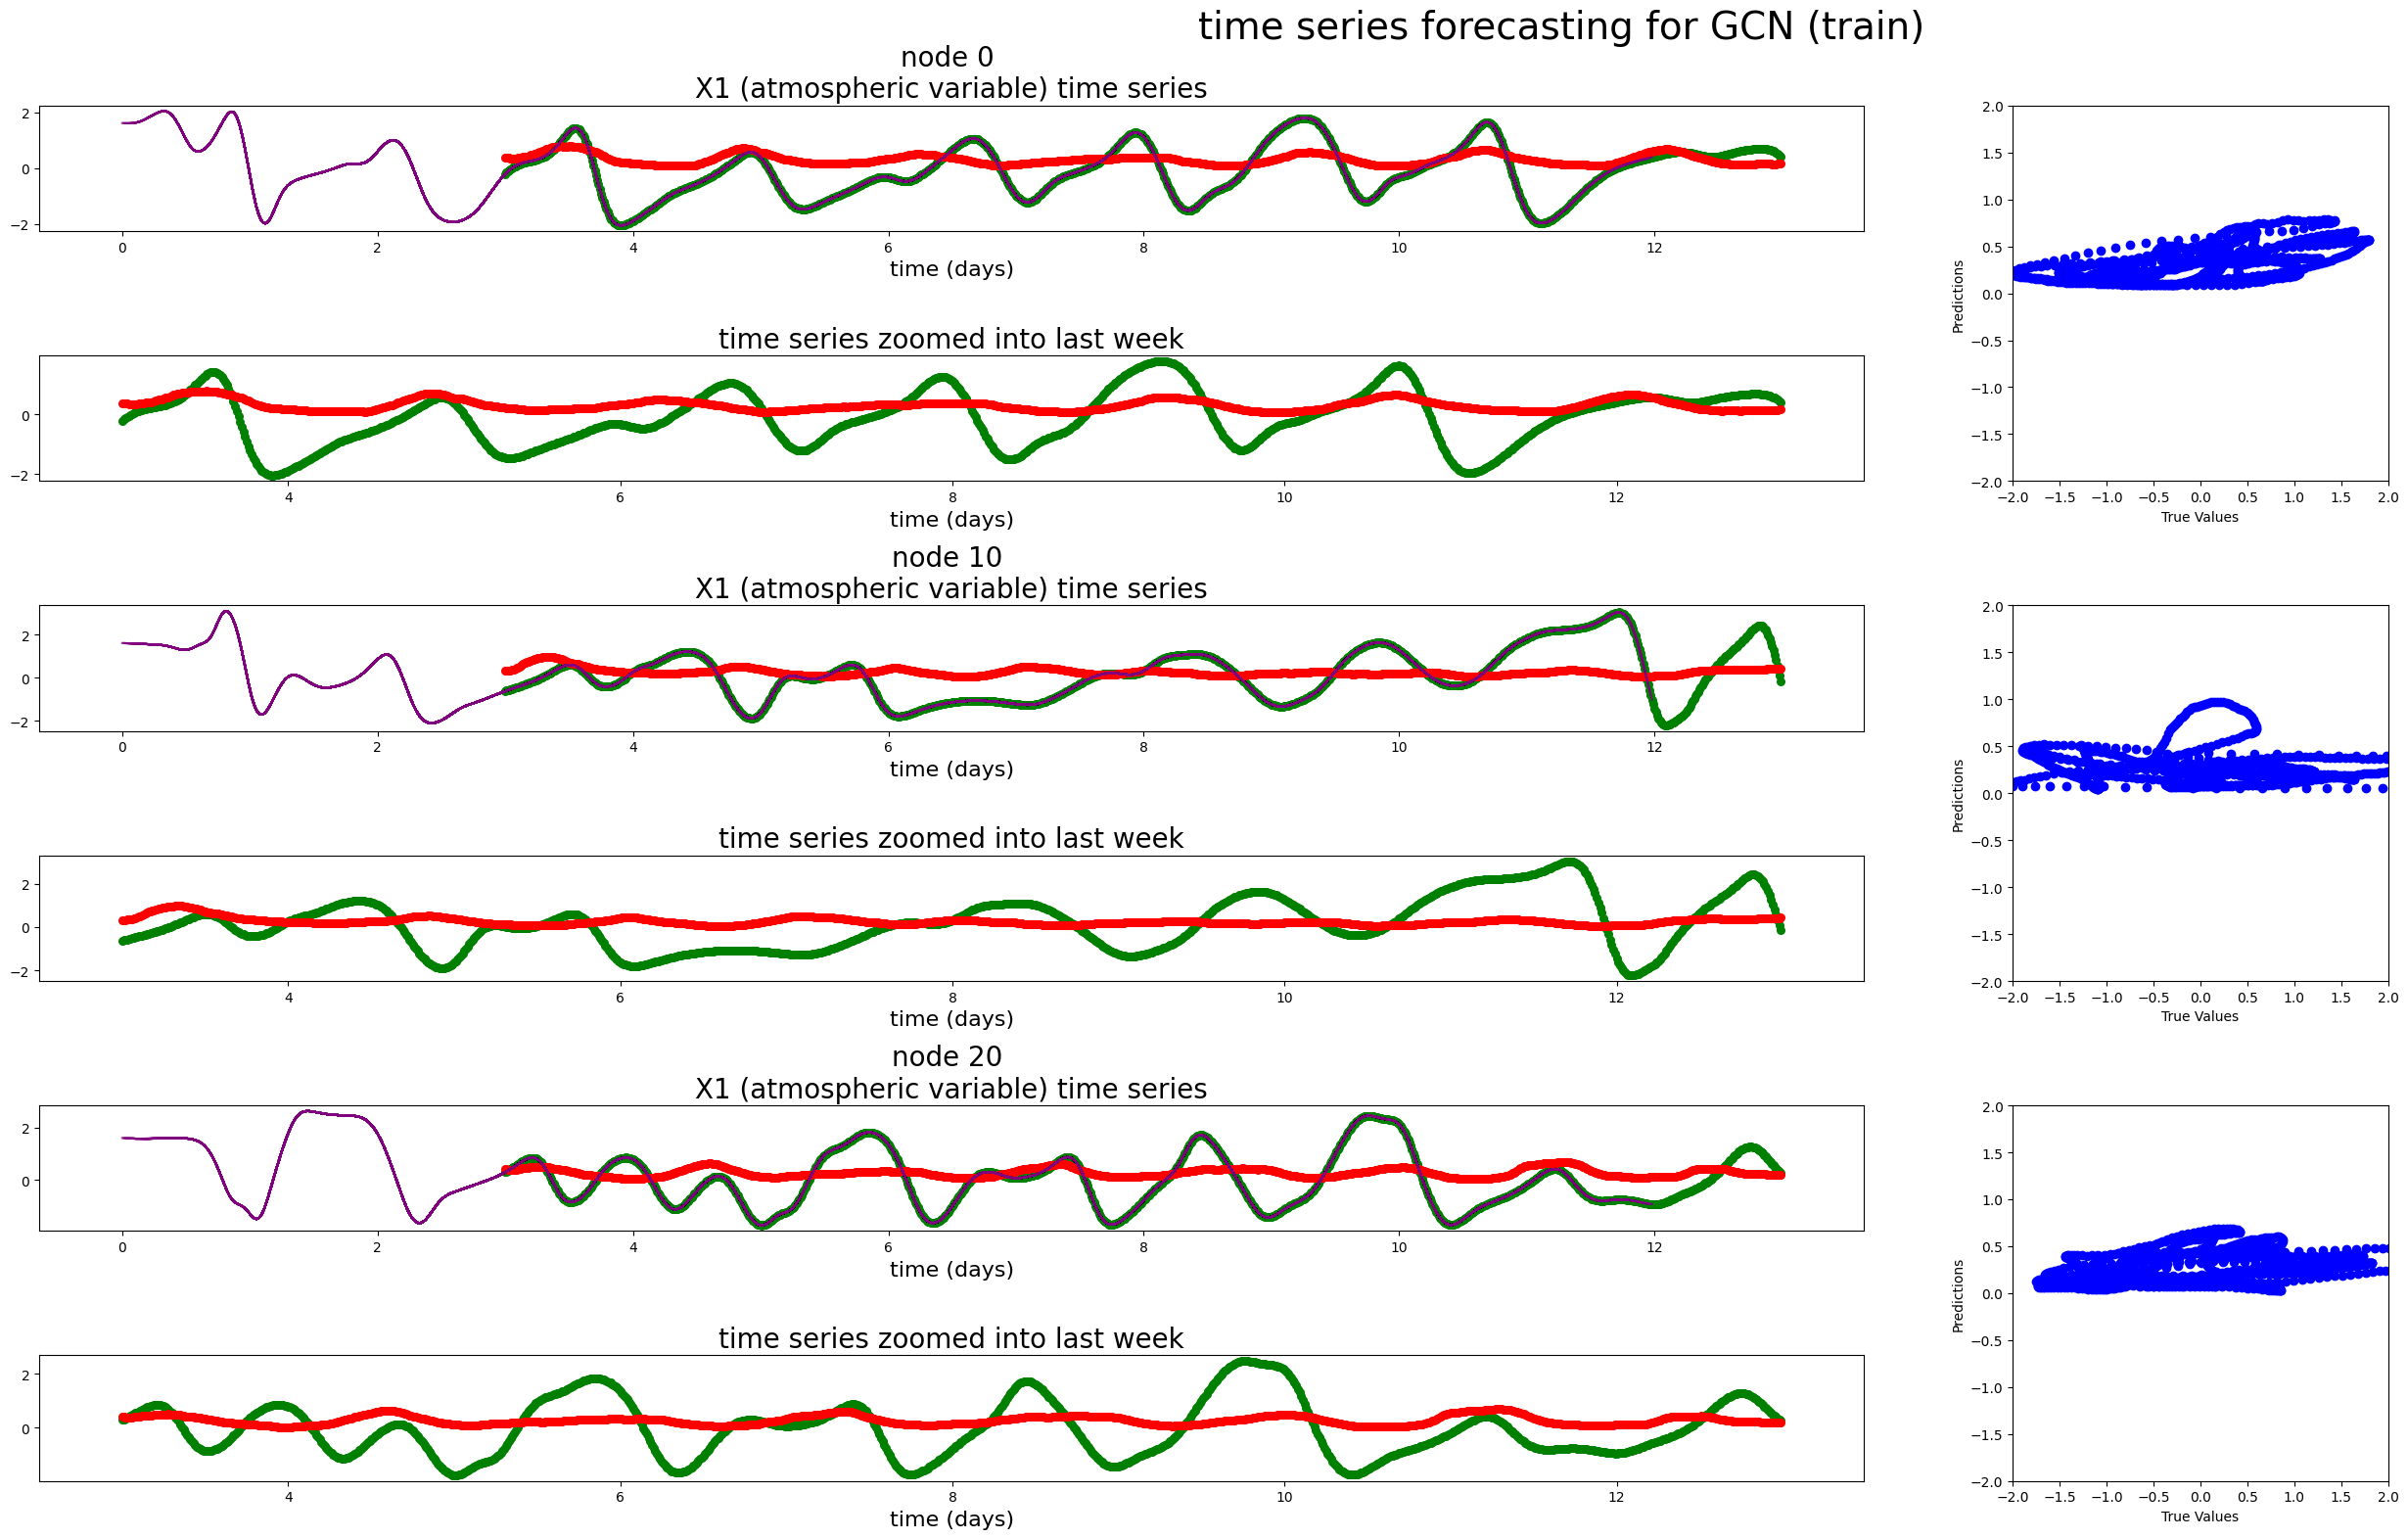

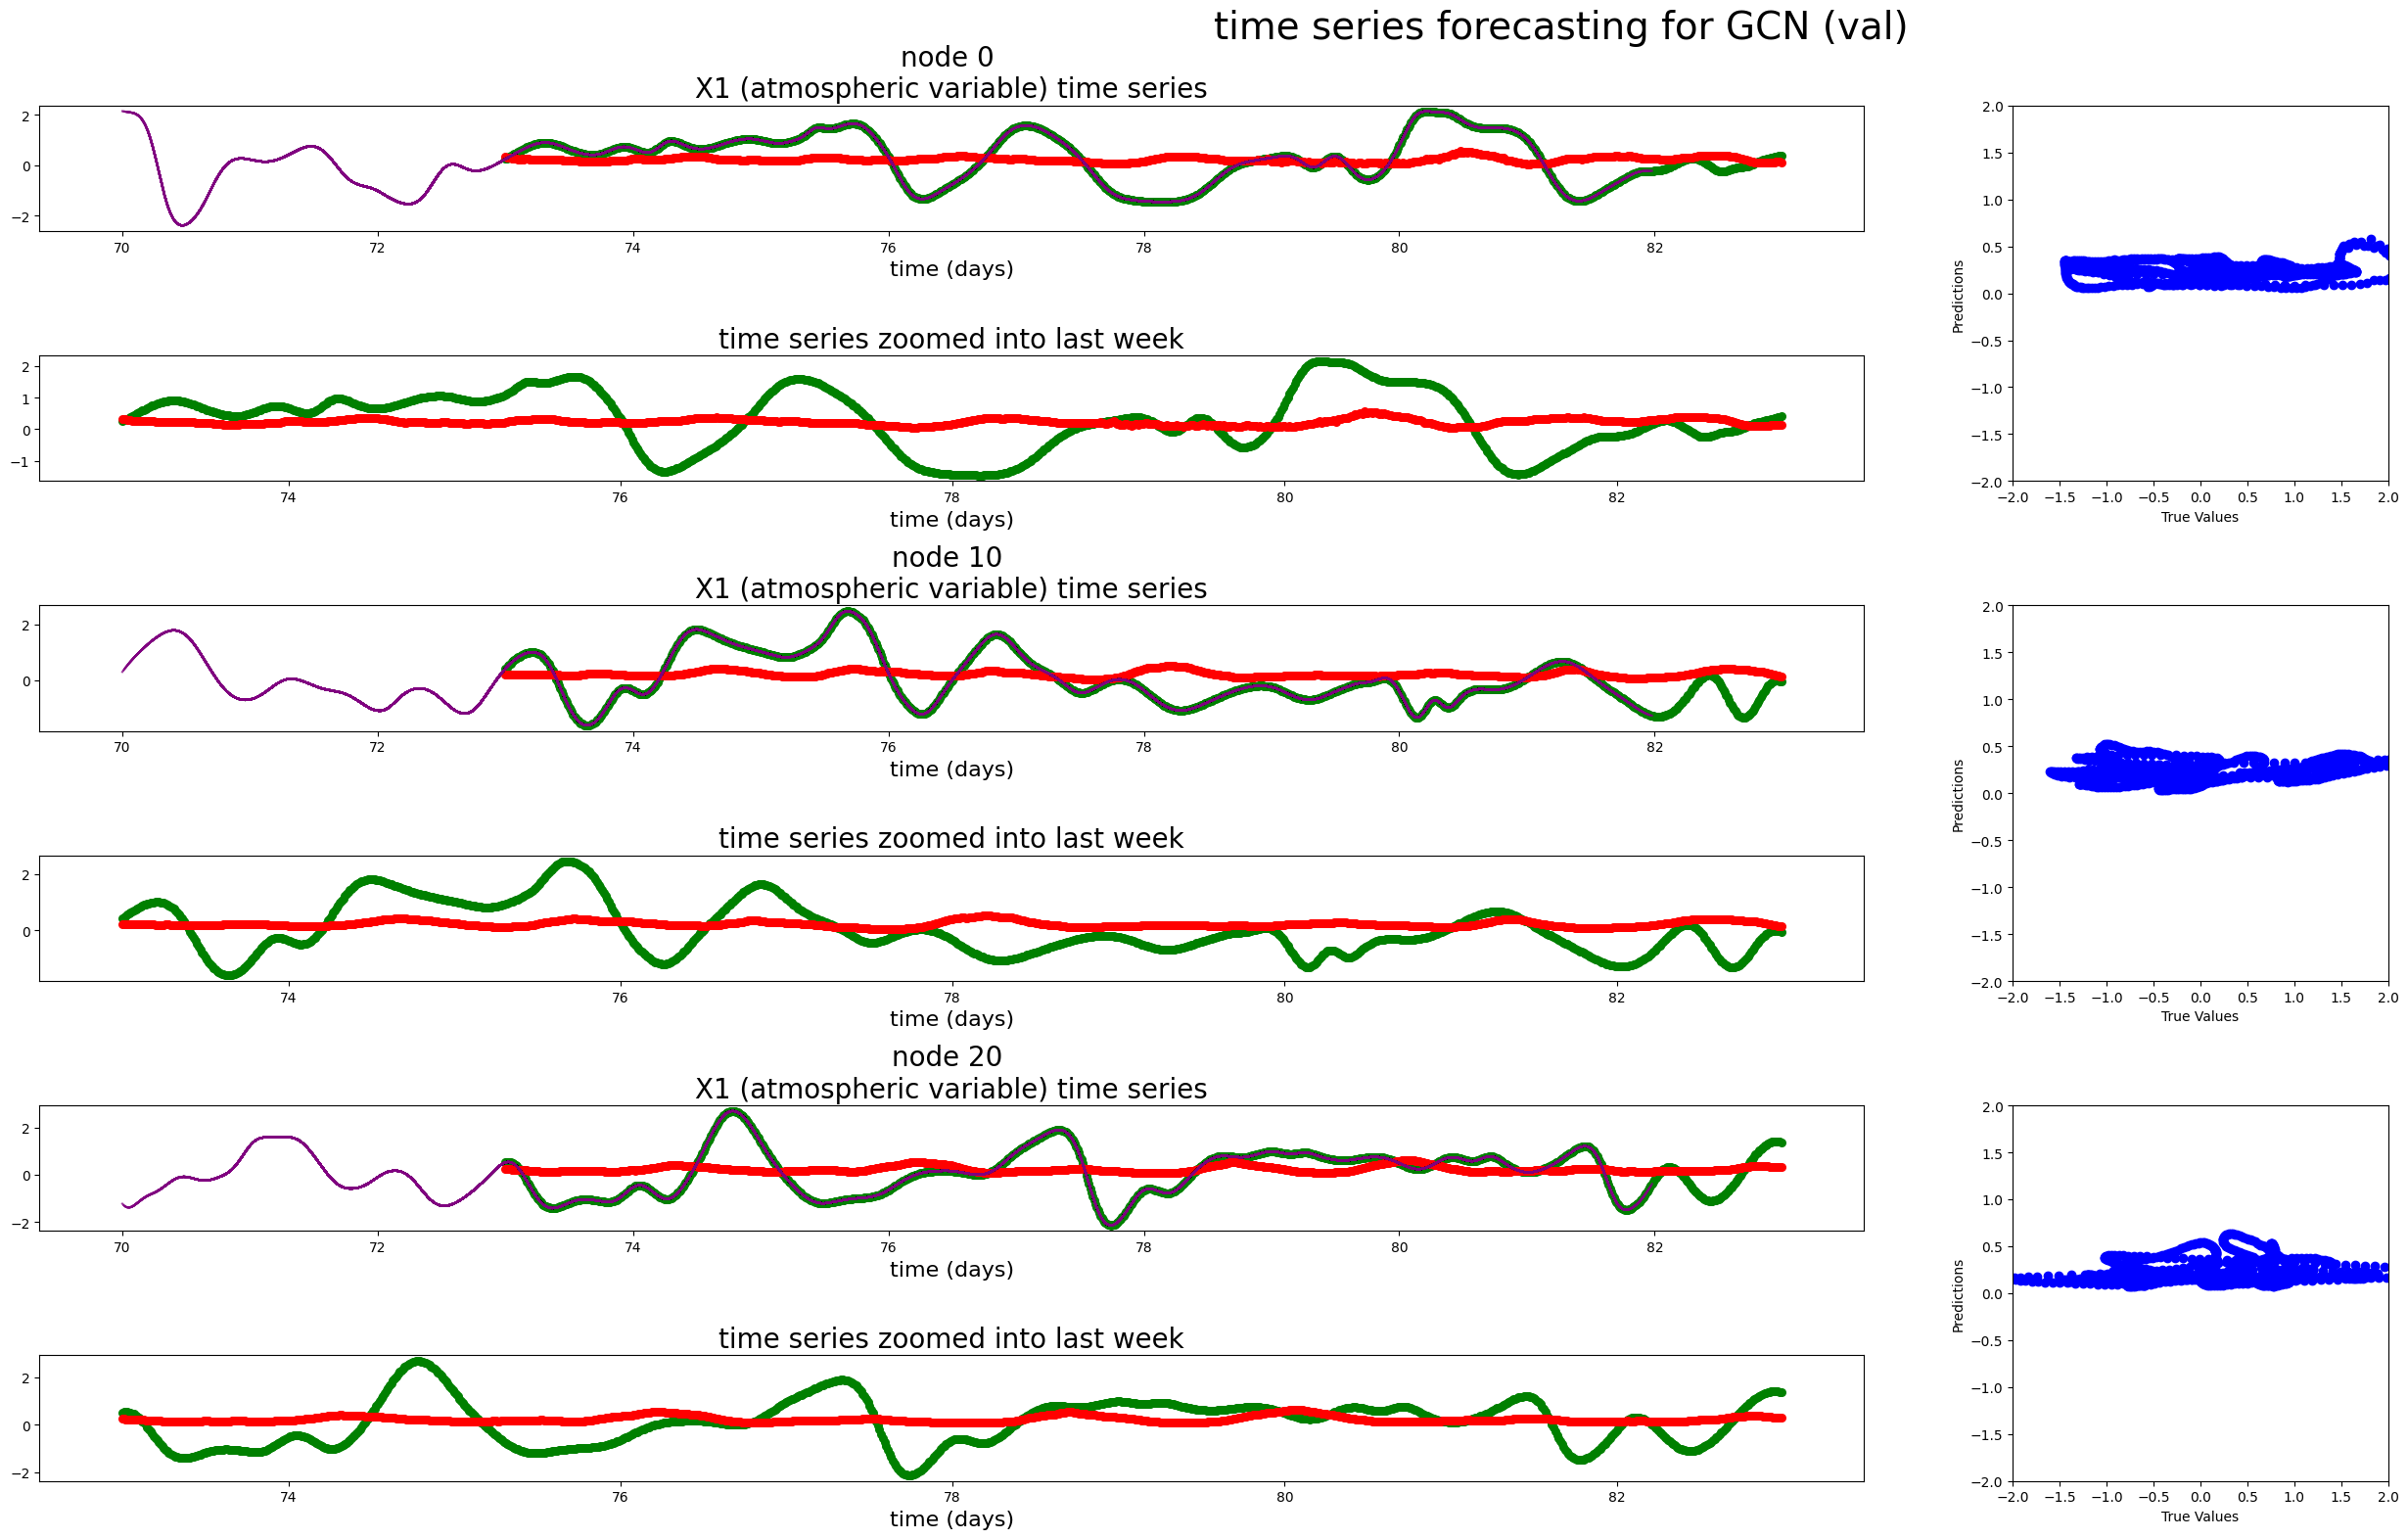

In [12]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(train[:1000],
                                                                  val[:1000],
                                                                  GCN_MSLE,
                                                                  history_MSLE,
                                                                  epochs=150)


is something wrong with the initializations? 

In [11]:
GCN_MSLE2, history_MSLE2, fname_MSLE2 = make_train_GCN(
    train,
    val,
    loss=MeanSquaredLogarithmicError(),
    activation="relu",
    epochs=150,
    eval_val=True,
    early_stopping=False,
    verbose=0)


32/32 [==============================] - 0s 8ms/step


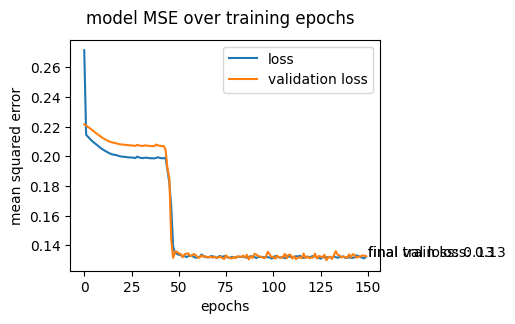

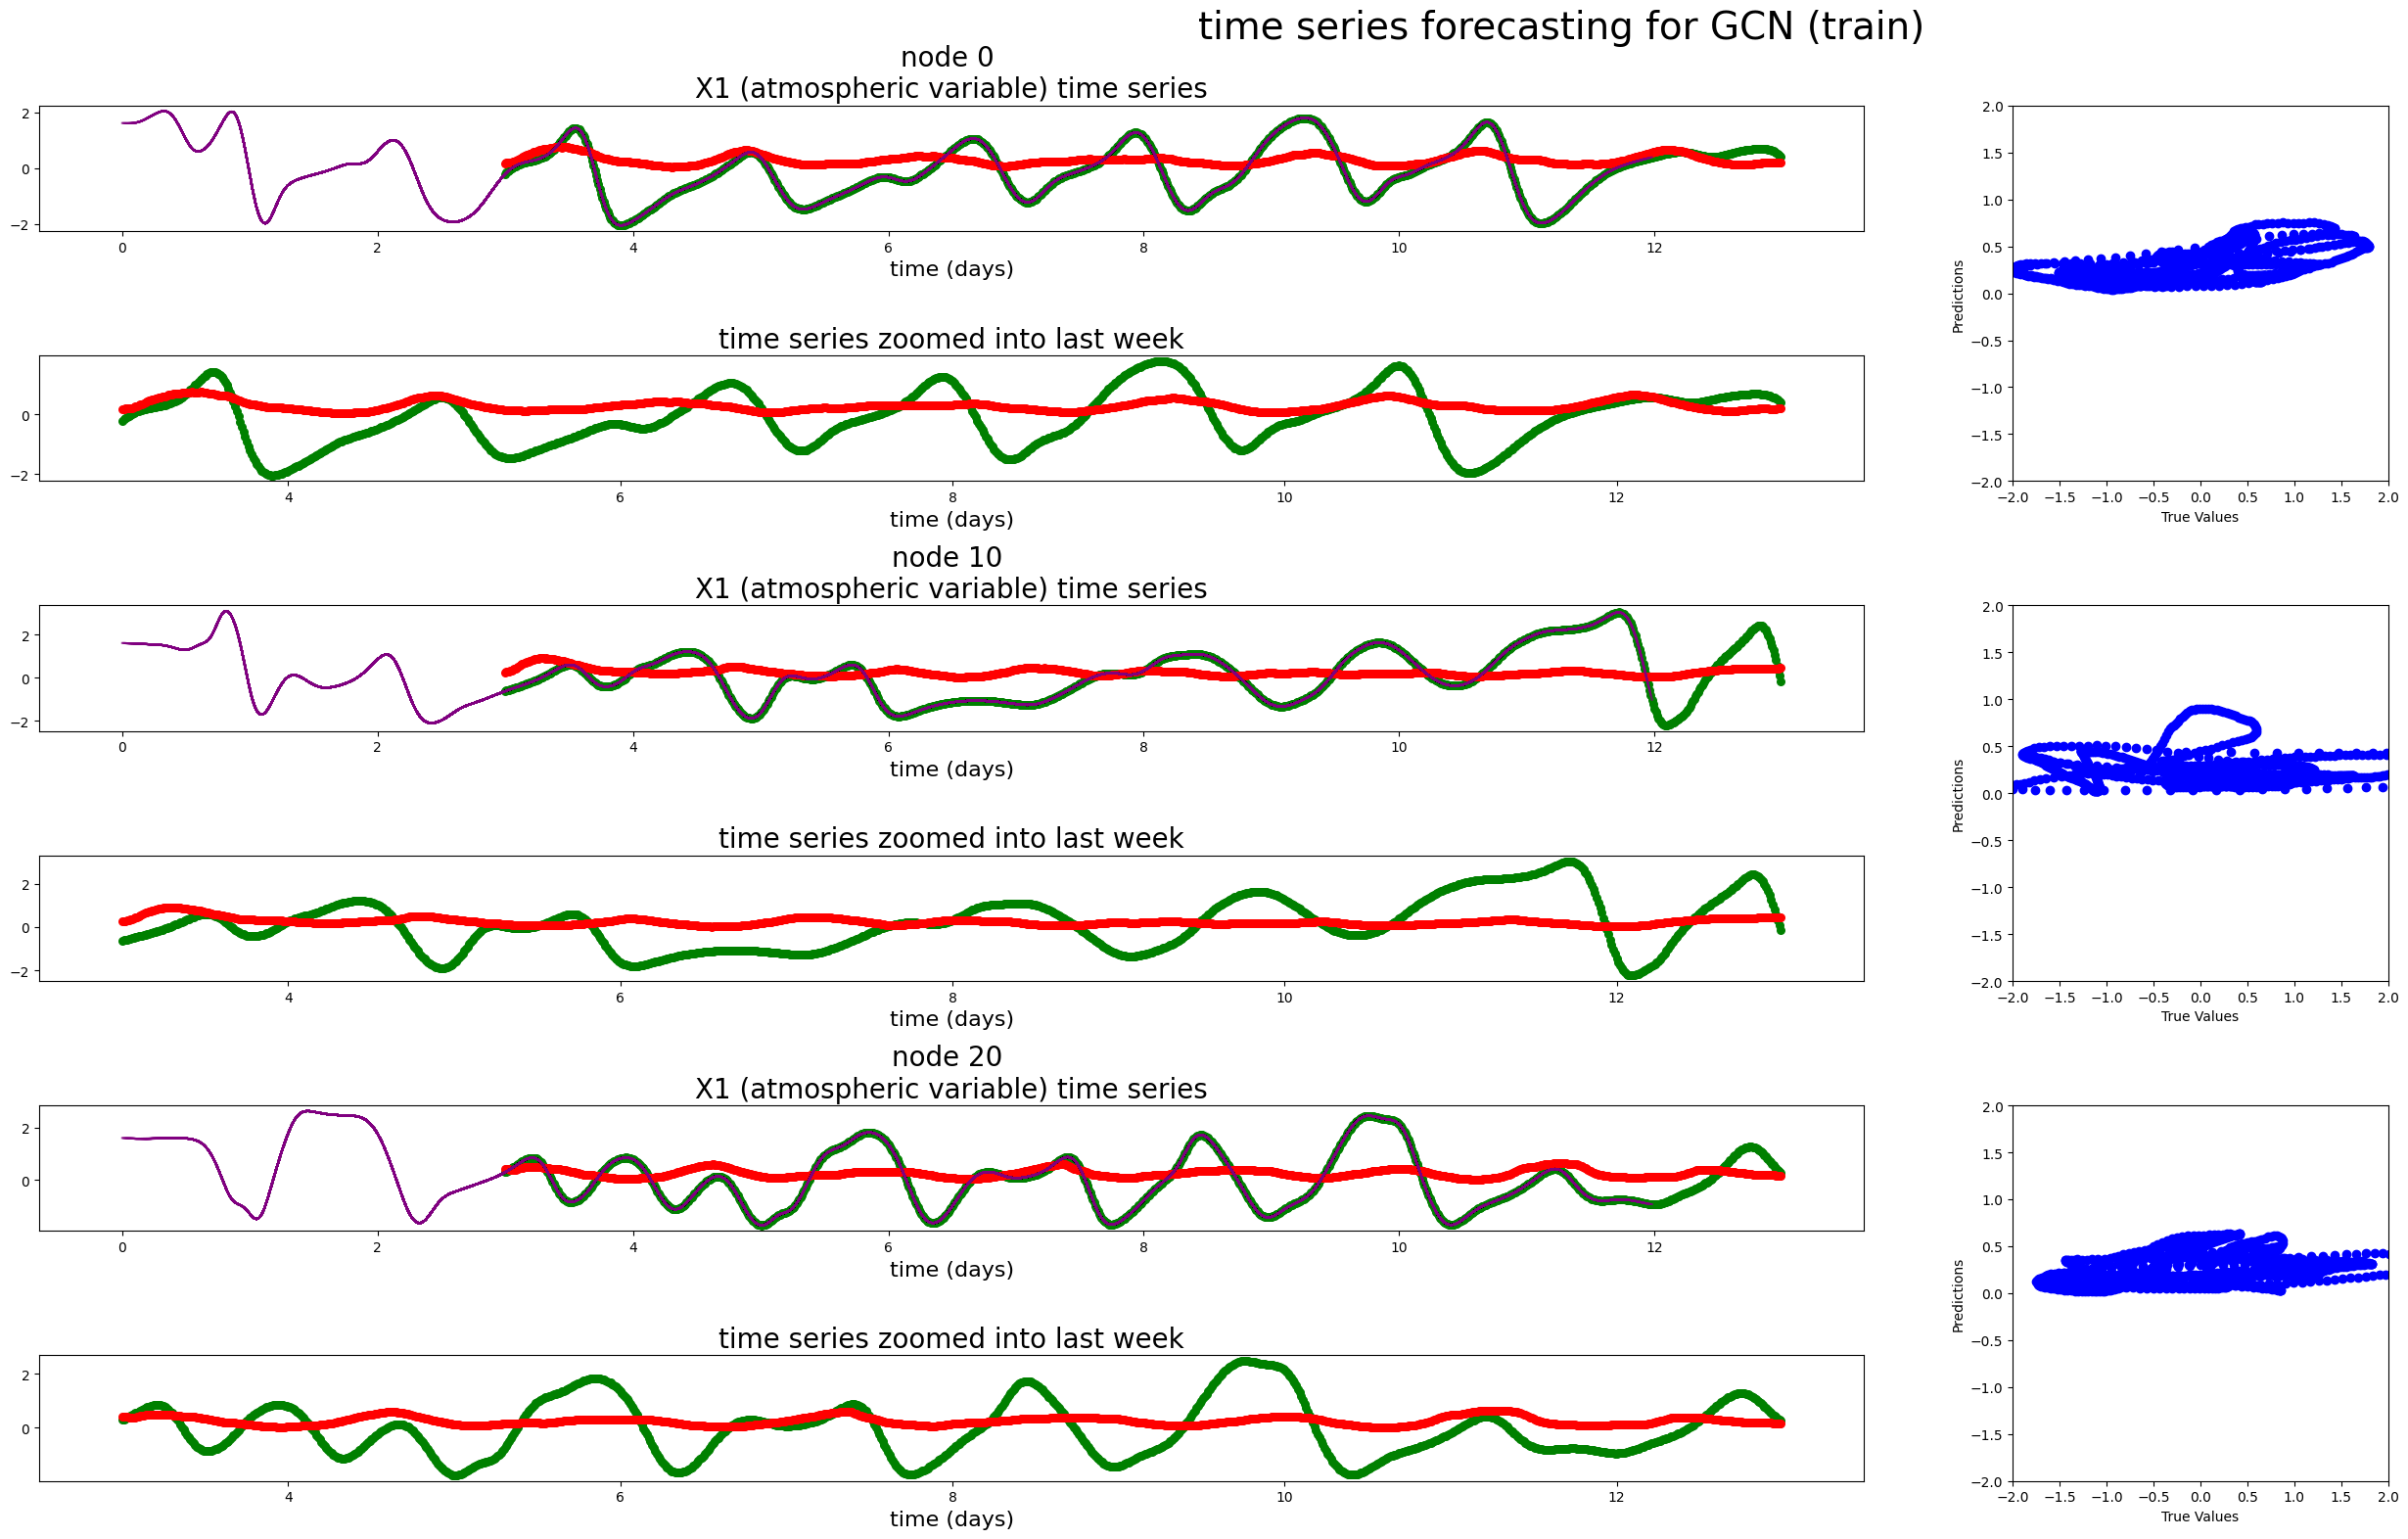

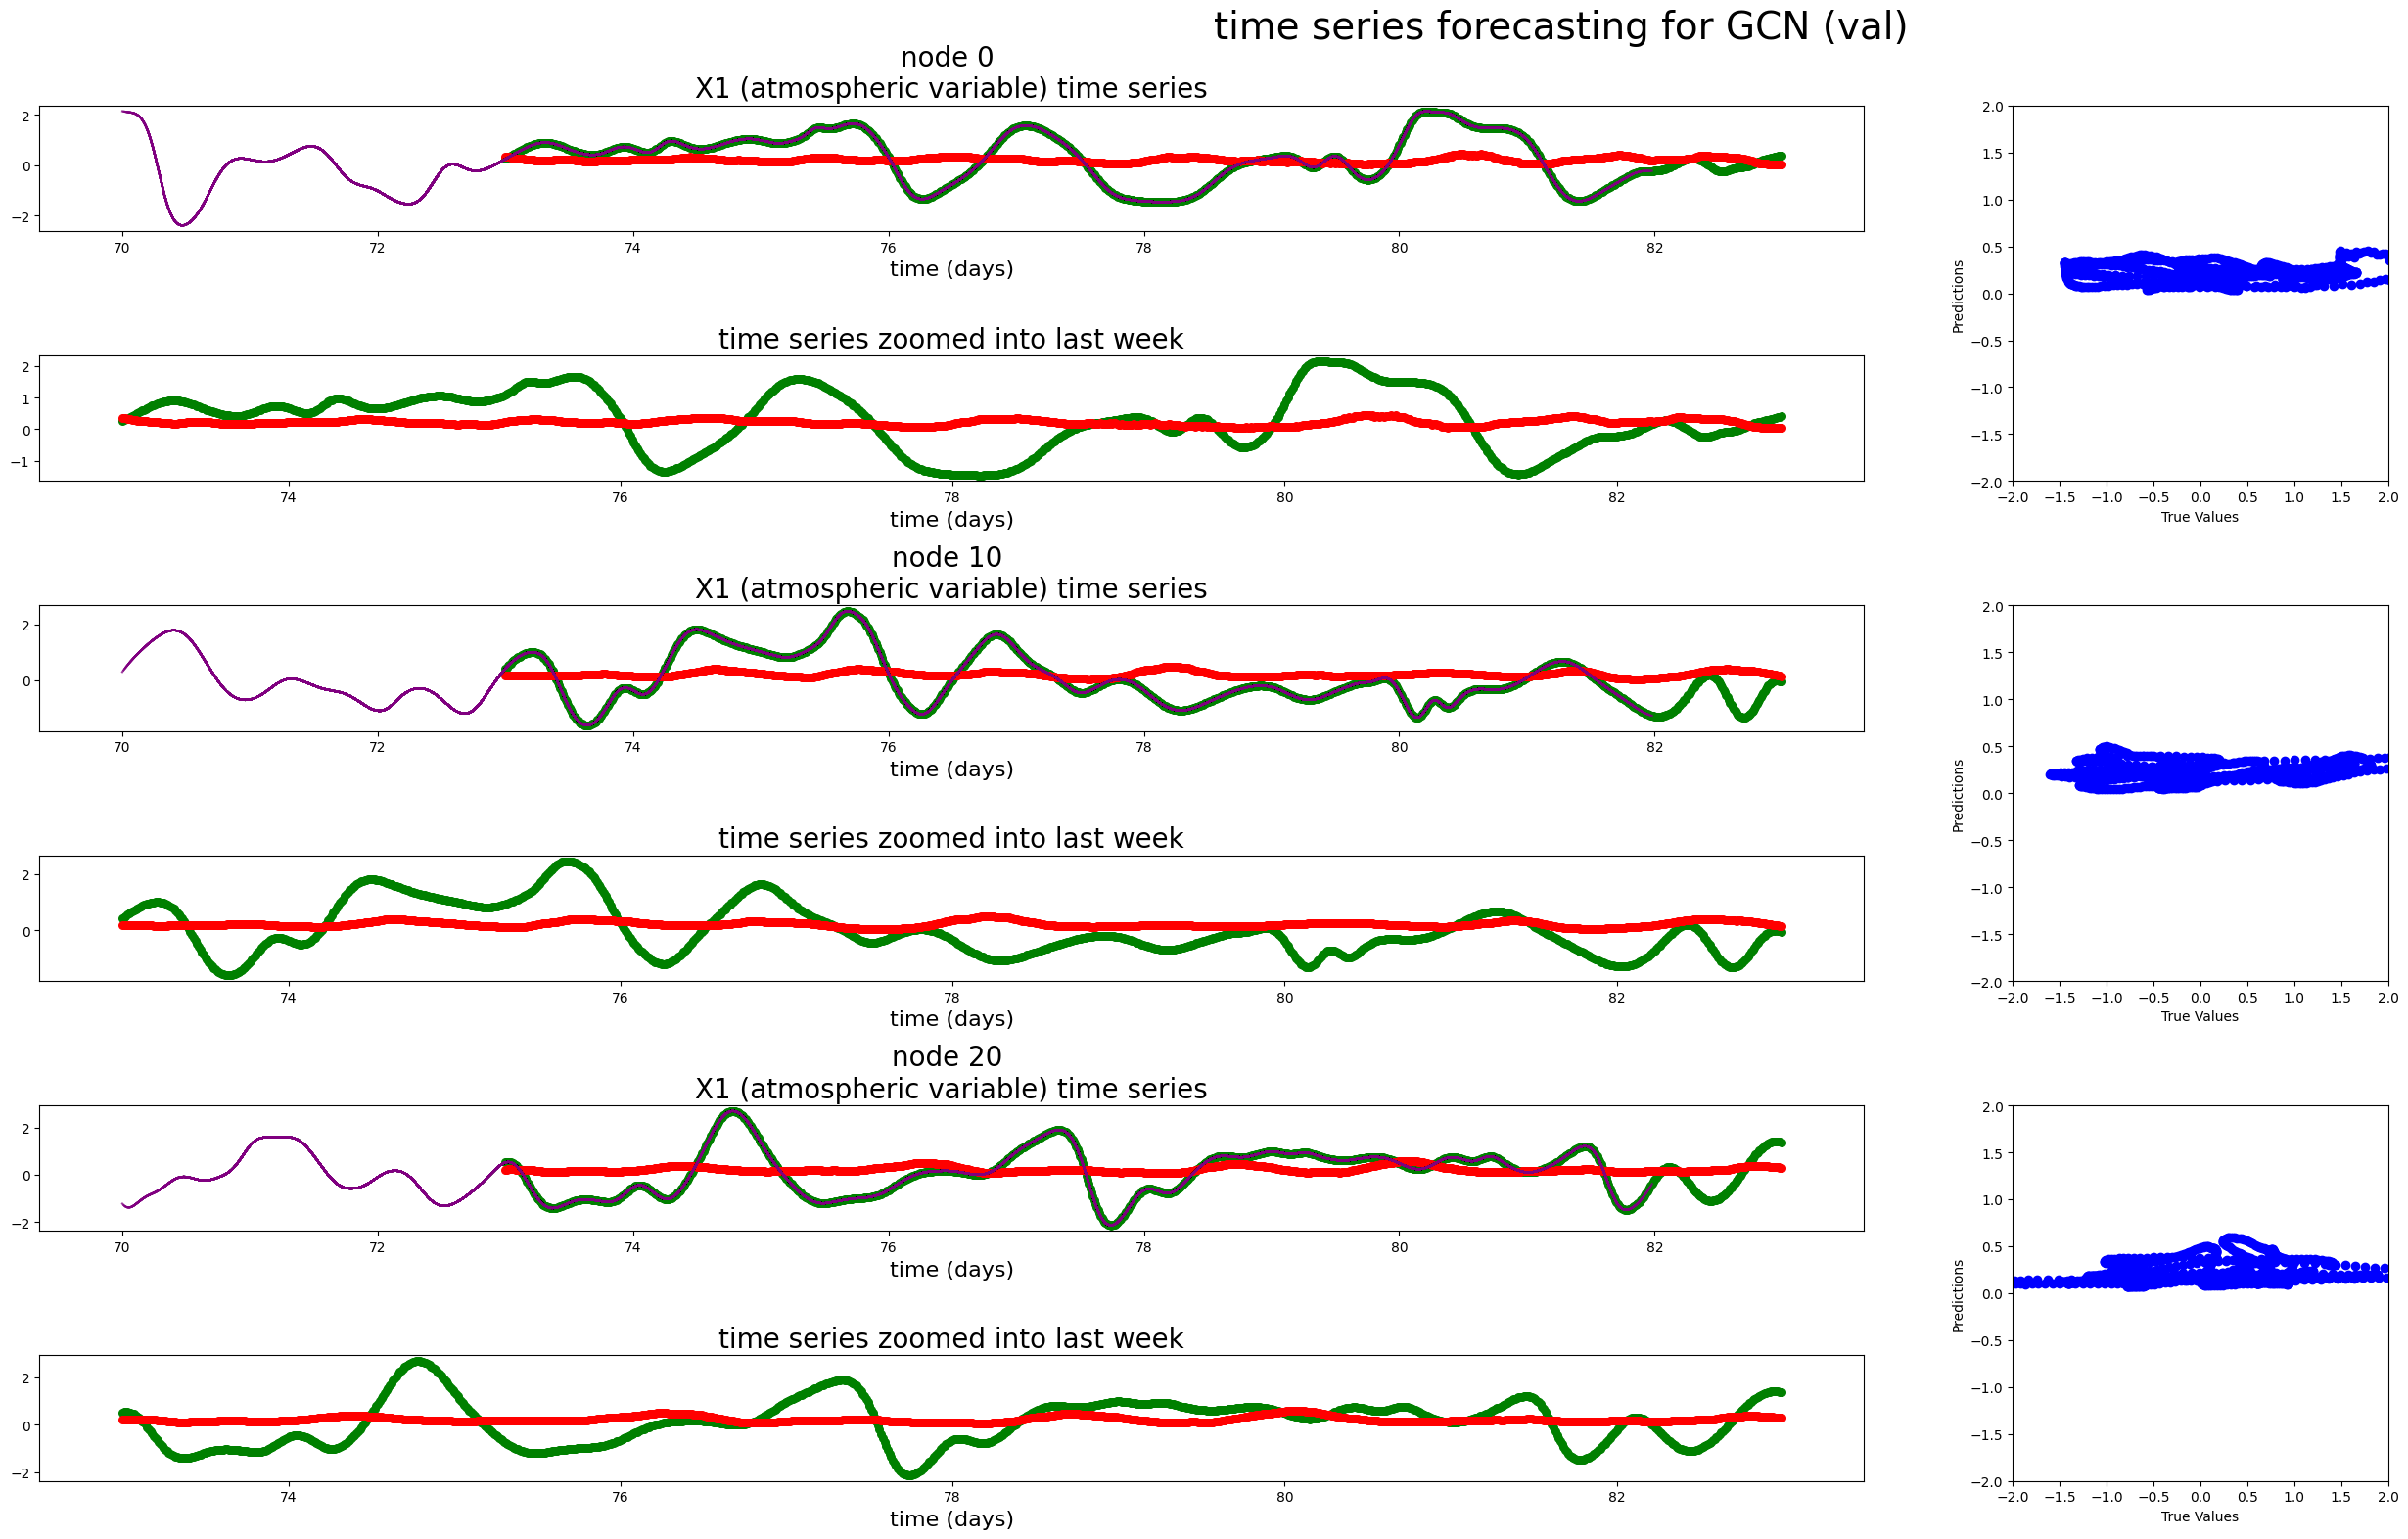

In [12]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000],
    val[:1000],
    GCN_MSLE2,
    history_MSLE2,
    epochs=150)
